### **Installation**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 658.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 85.5 MB/s eta 0:00:00
 

In [1]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### **LSTM**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Load and preprocess the data
def load_and_preprocess_data(file_path):
    """
    Load the CSV file and preprocess the data for LSTM training
    """
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, hourly_columns

def create_sequences_full_data(data, sequence_length):
    """
    Create sequences from ALL data for training
    """
    sequences = []
    targets = []
    user_info = []  # Keep track of which user each sequence belongs to

    # Group by user to create sequences
    for user_id in data['USER_ID'].unique()[:1000]:
        print(user_id)
        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')


        # Extract hourly features
        hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                         '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                         '8pm', '9pm', '10pm', '11pm']

        features = user_data[hourly_columns].values
        dates = user_data['DATE'].values

        # Create sequences for this user
        for i in range(len(features) - sequence_length):
            sequence = features[i:i+sequence_length]
            next_day_activity = features[i+sequence_length]

            # Target: predict next day's hourly pattern
            # We'll create multiple targets - one for each hour
            sequences.append(sequence)
            targets.append(next_day_activity)  # Full 24-hour pattern
            user_info.append({
                'user_id': user_id,
                'start_date': dates[i],
                'end_date': dates[i+sequence_length-1],
                'target_date': dates[i+sequence_length]
            })

    return np.array(sequences), np.array(targets), user_info

def create_lstm_model_multi_output(input_shape, output_dim=24):
    """
    Create LSTM model for predicting full 24-hour patterns
    """
    model = Sequential([
        LSTM(256, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(output_dim, activation='sigmoid')  # 24 outputs for 24 hours
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model



# Main training function
def train_full_model():
    """
    Train the model on ALL available data
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    SEQUENCE_LENGTH = 7  # Use 7 days to predict next day

    print("Loading and preprocessing data...")
    df, hourly_columns = load_and_preprocess_data(FILE_PATH)

    print(f"Data shape: {df.shape}")
    print(f"Number of unique users: {df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")

    # Create sequences from ALL data
    print("Creating sequences from ALL data...")
    X, y, user_info = create_sequences_full_data(df, SEQUENCE_LENGTH)

    print(f"Total sequences: {len(X)}")
    print(f"Sequence shape: {X.shape}")
    print(f"Target shape: {y.shape}")

    # Create and compile model
    print("Creating LSTM model")
    model = create_lstm_model_multi_output(
        input_shape=(SEQUENCE_LENGTH, len(hourly_columns)),
        output_dim=24
    )

    print("Model architecture:")
    model.summary()

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='loss',
        patience=15,
        restore_best_weights=True
    )

    # Train the model on ALL data
    print("Training model on FULL dataset...")
    history = model.fit(
        X, y,
        batch_size=16,
        epochs=5,
        callbacks=[early_stopping],
        verbose=1
    )


    # Save the model
    model.save('notification_lstm_full_model.h5')
    print("Model saved as 'notification_lstm_full_model.h5'")

    # Save additional info
    np.save('model_info.npy', {
        'hourly_columns': hourly_columns,
        'sequence_length': SEQUENCE_LENGTH,
        'user_info_sample': user_info[:5]  # Save a sample for reference
    }, allow_pickle=True)
    return model, history, df, hourly_columns
    # print("=== EXAMPLE PREDICTION ===")
    # user_id = "00001d6eecdf78d72d9cc90d9a0a99c7"
    # df_result, predictions = notification_lstm_full_model(
    #     user_id=user_id,
    #     save_csv=True)


def quick_test_model(model, df, hourly_columns, sequence_length=7):
    """
    Quick test of the trained model
    """
    # Test on a sample user
    sample_user = df['USER_ID'].iloc[8]
    user_data = df[df['USER_ID'] == sample_user].copy()
    user_data = user_data.sort_values('DATE')

    if len(user_data) >= sequence_length + 1:
        features = user_data[hourly_columns].values
        test_sequence = features[:sequence_length].reshape(1, sequence_length, 24)
        actual_next_day = features[sequence_length]

        prediction = model.predict(test_sequence)[0]
        predicted_binary = (prediction > 0.5).astype(int)

        print(f"\nQuick test for user: {sample_user}")
        print(f"Actual next day:    {actual_next_day}")
        print(f"Predicted (prob):   {prediction}")
        print(f"Predicted (binary): {predicted_binary}")
        print(f"Accuracy: {np.mean(actual_next_day == predicted_binary):.2f}")

if __name__ == "__main__":
    # Train the model
    model, history, df, hourly_columns = train_full_model()

    # Quick test
    quick_test_model(model, df, hourly_columns)

Loading and preprocessing data...
Data shape: (6279000, 26)
Number of unique users: 232840
Date range: 2025-01-05 00:00:00 to 2025-04-28 00:00:00
Creating sequences from ALL data...
00001d6eecdf78d72d9cc90d9a0a99c7
000033ef96774b50806529379c6b69c3
00020d3a2f68244d04c004aade84fe4f
00020ff0c04a2a03c307faedc8a389ab
000253845e38533e9e156dd4973d85c5
0002609e9c9d4cd8a3b776edf7336d94
000267d3ece9dcf6551f22d8a7299016
0002eab010b3470b84df7a280d135af9
000303db4509d199169157cc02baa8a9
00031510761c00a9f6477671538283db
0003296bc65a205cd51f3554e18dd9a8
000373f37f604bd69193d151b495d66e
0004439d44f7d6ff1a3afd476d3a2464
00047b703bddb24809f8105adf1e55fc
000491e233d3dd6db4ea9edd6e58ca45
0005337f505e41a2aced763e12765fb6
0005ace1a289c3785d4908f4ac595b51
0005f33361b1a9d464a0be3002dc6e02
00067773bfd7cf20efff8ead3b6ad8ff
0006af147c1b496dabf781dd9cc063e4
0006b5e53f804f7fa54ef8a8b505ade3
0007e832ebbb4a72ba75d41f400b27a0
000874f3174049d88e8badbb210d63ca
00087f24bd314206aab2dd7a38b925c4
0009c7a905521cae11a50f9f5a

Raw Data ( LSTM NEural Network Random forest )

raw data + probability  (LSTM NEural Network Random forest)

Raw data + clusters  (LSTM NEural Network Random forest)

### **Neural NetworK**

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.24.3

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 87.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.30 which is incompatible.
orbax-checkpoint 0.11.13 requires jax>=0.5.0, but you have jax 0.4.30 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.


Loading and preprocessing data...
Data shape: (6279000, 26)
Number of unique users: 232840
Date range: 2025-01-05 00:00:00 to 2025-04-28 00:00:00
Creating sequences from ALL data...
00001d6eecdf78d72d9cc90d9a0a99c7
000033ef96774b50806529379c6b69c3
00020d3a2f68244d04c004aade84fe4f
00020ff0c04a2a03c307faedc8a389ab
000253845e38533e9e156dd4973d85c5
0002609e9c9d4cd8a3b776edf7336d94
000267d3ece9dcf6551f22d8a7299016
0002eab010b3470b84df7a280d135af9
000303db4509d199169157cc02baa8a9
00031510761c00a9f6477671538283db
0003296bc65a205cd51f3554e18dd9a8
000373f37f604bd69193d151b495d66e
0004439d44f7d6ff1a3afd476d3a2464
00047b703bddb24809f8105adf1e55fc
000491e233d3dd6db4ea9edd6e58ca45
0005337f505e41a2aced763e12765fb6
0005ace1a289c3785d4908f4ac595b51
0005f33361b1a9d464a0be3002dc6e02
00067773bfd7cf20efff8ead3b6ad8ff
0006af147c1b496dabf781dd9cc063e4
0006b5e53f804f7fa54ef8a8b505ade3
0007e832ebbb4a72ba75d41f400b27a0
000874f3174049d88e8badbb210d63ca
00087f24bd314206aab2dd7a38b925c4
0009c7a905521cae11a50f9f5a

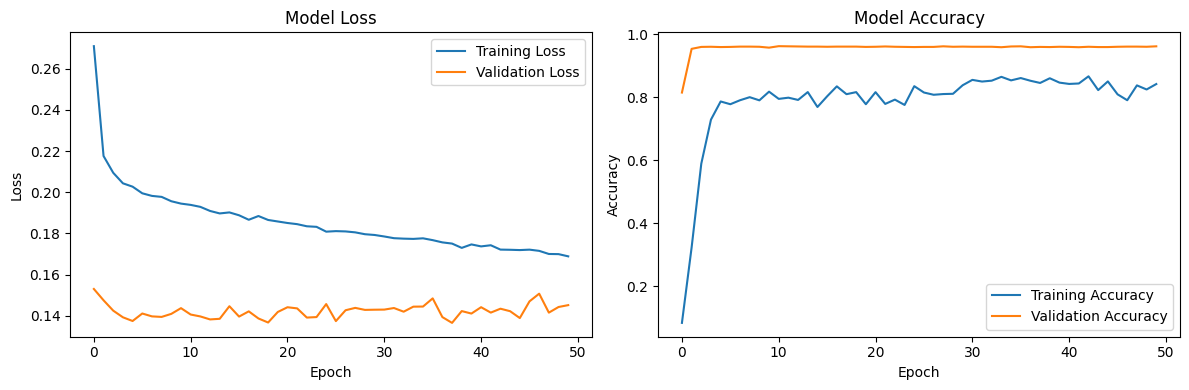

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Load and preprocess the data
def load_and_preprocess_data(file_path):
    """
    Load the CSV file and preprocess the data for Neural Network training
    """
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, hourly_columns

def create_sequences_full_data(data, sequence_length):
    """
    Create flattened sequences from ALL data for Neural Network training
    """
    sequences = []
    targets = []
    user_info = []  # Keep track of which user each sequence belongs to

    # Group by user to create sequences
    for user_id in data['USER_ID'].unique()[:1000]:
        print(user_id)
        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')

        # Extract hourly features
        hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                         '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                         '8pm', '9pm', '10pm', '11pm']

        features = user_data[hourly_columns].values
        dates = user_data['DATE'].values

        # Create sequences for this user
        for i in range(len(features) - sequence_length):
            # Flatten the sequence for neural network input
            sequence = features[i:i+sequence_length].flatten()  # Flatten 2D to 1D
            next_day_activity = features[i+sequence_length]

            # Target: predict next day's hourly pattern
            sequences.append(sequence)
            targets.append(next_day_activity)  # Full 24-hour pattern
            user_info.append({
                'user_id': user_id,
                'start_date': dates[i],
                'end_date': dates[i+sequence_length-1],
                'target_date': dates[i+sequence_length]
            })

    return np.array(sequences), np.array(targets), user_info

def create_nn_model_multi_output(input_dim, output_dim=24):
    """
    Create Neural Network model for predicting full 24-hour patterns
    """
    model = Sequential([
        Dense(512, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # 24 outputs for 24 hours
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Main training function
def train_full_model():
    """
    Train the model on ALL available data
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    SEQUENCE_LENGTH = 7  # Use 7 days to predict next day

    print("Loading and preprocessing data...")
    df, hourly_columns = load_and_preprocess_data(FILE_PATH)

    print(f"Data shape: {df.shape}")
    print(f"Number of unique users: {df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")

    # Create sequences from ALL data
    print("Creating sequences from ALL data...")
    X, y, user_info = create_sequences_full_data(df, SEQUENCE_LENGTH)

    print(f"Total sequences: {len(X)}")
    print(f"Sequence shape: {X.shape}")
    print(f"Target shape: {y.shape}")

    # Optional: Normalize the input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create and compile model
    print("Creating Neural Network model")
    model = create_nn_model_multi_output(
        input_dim=X_scaled.shape[1],  # Flattened sequence length * features
        output_dim=24
    )

    print("Model architecture:")
    model.summary()

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='loss',
        patience=15,
        restore_best_weights=True
    )

    # Train the model on ALL data
    print("Training model on FULL dataset...")
    history = model.fit(
        X_scaled, y,
        batch_size=32,  # Increased batch size for NN
        epochs=50,      # More epochs for NN
        callbacks=[early_stopping],
        verbose=1,
        validation_split=0.1  # Add validation split
    )

    # Save the model and scaler
    model.save('notification_nn_full_model.h5')
    print("Model saved as 'notification_nn_full_model.h5'")

    # Save additional info including scaler
    np.save('model_info.npy', {
        'hourly_columns': hourly_columns,
        'sequence_length': SEQUENCE_LENGTH,
        'user_info_sample': user_info[:5],  # Save a sample for reference
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_
    }, allow_pickle=True)

    return model, history, df, hourly_columns, scaler

def quick_test_model(model, df, hourly_columns, scaler, sequence_length=7):
    """
    Quick test of the trained model
    """
    # Test on a sample user
    sample_user = df['USER_ID'].iloc[8]
    user_data = df[df['USER_ID'] == sample_user].copy()
    user_data = user_data.sort_values('DATE')

    if len(user_data) >= sequence_length + 1:
        features = user_data[hourly_columns].values
        test_sequence = features[:sequence_length].flatten().reshape(1, -1)  # Flatten and reshape
        actual_next_day = features[sequence_length]

        # Scale the test sequence
        test_sequence_scaled = scaler.transform(test_sequence)

        prediction = model.predict(test_sequence_scaled)[0]
        predicted_binary = (prediction > 0.5).astype(int)

        print(f"\nQuick test for user: {sample_user}")
        print(f"Actual next day:    {actual_next_day}")
        print(f"Predicted (prob):   {prediction}")
        print(f"Predicted (binary): {predicted_binary}")
        print(f"Accuracy: {np.mean(actual_next_day == predicted_binary):.2f}")

def predict_with_nn_model(model_path, scaler_info, user_sequence):
    """
    Load trained model and make predictions
    """
    # Load model
    model = tf.keras.models.load_model(model_path)

    # Recreate scaler
    scaler = StandardScaler()
    scaler.mean_ = scaler_info['scaler_mean']
    scaler.scale_ = scaler_info['scaler_scale']

    # Flatten and scale input
    user_sequence_flat = user_sequence.flatten().reshape(1, -1)
    user_sequence_scaled = scaler.transform(user_sequence_flat)

    # Make prediction
    prediction = model.predict(user_sequence_scaled)[0]
    predicted_binary = (prediction > 0.5).astype(int)

    return prediction, predicted_binary

if __name__ == "__main__":
    # Train the model
    model, history, df, hourly_columns, scaler = train_full_model()

    # Quick test
    quick_test_model(model, df, hourly_columns, scaler)

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### **Neural Network(Raw) Monday - Sunday 12am - 11ppm**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_path):
    """
    Load the CSV file and preprocess the data for Neural Network training
    """
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Add day of week information
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
    df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week
    df['YEAR'] = df['DATE'].dt.year
    df['WEEK_YEAR'] = df['YEAR'].astype(str) + '_' + df['WEEK_NUMBER'].astype(str)

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, hourly_columns

def create_weekly_sequences(data, sequence_weeks=1):
    """
    Create weekly sequences from data for Neural Network training
    Input: sequence_weeks weeks to predict next week's pattern
    """
    sequences = []
    targets = []
    user_info = []

    # Days of week in order
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Hourly columns
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    # Group by user to create sequences
    for user_id in data['USER_ID'].unique()[:1000]:
        print(f"Processing user: {user_id}")
        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')

        # Group by week for this user
        weekly_data = {}
        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]

            # Check if we have all 7 days for this week
            if len(week_data) == 7:
                # Sort by day of week to ensure Monday-Sunday order
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()

                # Check if we have data for all days (no NaN after reindexing)
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values  # Shape: (7, 24)

        # Create sequences from complete weeks
        week_keys = sorted(weekly_data.keys())

        for i in range(len(week_keys) - sequence_weeks):
            # Get input weeks (flatten them)
            input_weeks = []
            for j in range(sequence_weeks):
                week_data = weekly_data[week_keys[i + j]]  # Shape: (7, 24)
                input_weeks.append(week_data.flatten())  # Flatten to (168,)

            # Concatenate all input weeks
            sequence = np.concatenate(input_weeks)  # Shape: (sequence_weeks * 168,)

            # Get target week
            target_week = weekly_data[week_keys[i + sequence_weeks]]  # Shape: (7, 24)
            target = target_week.flatten()  # Flatten to (168,)

            sequences.append(sequence)
            targets.append(target)
            user_info.append({
                'user_id': user_id,
                'input_weeks': [week_keys[i + j] for j in range(sequence_weeks)],
                'target_week': week_keys[i + sequence_weeks]
            })

    return np.array(sequences), np.array(targets), user_info

def create_nn_model_weekly(input_dim, output_dim=168):  # 7 days * 24 hours = 168
    """
    Create Neural Network model for predicting full weekly patterns (Monday-Sunday, 12am-11pm)
    """
    model = Sequential([
        Dense(1024, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # 168 outputs for 7 days * 24 hours
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_weekly_model():
    """
    Train the model on weekly patterns
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    SEQUENCE_WEEKS = 1  # Use 1 week to predict next week

    print("Loading and preprocessing data...")
    df, hourly_columns = load_and_preprocess_data(FILE_PATH)

    print(f"Data shape: {df.shape}")
    print(f"Number of unique users: {df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
    print(f"Unique weeks: {df['WEEK_YEAR'].nunique()}")

    # Create weekly sequences
    print("Creating weekly sequences...")
    X, y, user_info = create_weekly_sequences(df, SEQUENCE_WEEKS)

    print(f"Total weekly sequences: {len(X)}")
    print(f"Input sequence shape: {X.shape}")  # Should be (n_samples, 168) for 1 week
    print(f"Target shape: {y.shape}")          # Should be (n_samples, 168) for 1 week

    if len(X) == 0:
        print("No complete weekly sequences found! Check your data.")
        return None, None, None, None, None

    # Normalize the input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create and compile model
    print("Creating Neural Network model for weekly prediction")
    model = create_nn_model_weekly(
        input_dim=X_scaled.shape[1],  # 168 features for 1 week input
        output_dim=168  # 168 outputs for 1 week prediction
    )

    print("Model architecture:")
    model.summary()

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # Train the model
    print("Training model on weekly patterns...")
    history = model.fit(
        X_scaled, y,
        batch_size=16,  # Smaller batch size for weekly data
        epochs=100,     # More epochs for weekly patterns
        callbacks=[early_stopping],
        verbose=1,
        validation_split=0.2  # 20% validation split
    )

    # Save the model and scaler
    model.save('notification_nn_weekly_model.h5')
    print("Model saved as 'notification_nn_weekly_model.h5'")

    # Save additional info including scaler
    np.save('weekly_model_info.npy', {
        'hourly_columns': hourly_columns,
        'sequence_weeks': SEQUENCE_WEEKS,
        'user_info_sample': user_info[:5],
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_
    }, allow_pickle=True)

    return model, history, df, hourly_columns, scaler

def quick_test_weekly_model(model, df, hourly_columns, scaler, sequence_weeks=1):
    """
    Quick test of the trained weekly model with detailed comparison
    """
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Find a user with sufficient weekly data
    test_user = None
    for user_id in df['USER_ID'].unique()[:100]:  # Check first 100 users
        user_data = df[df['USER_ID'] == user_id].sort_values('DATE')
        weekly_data = {}

        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]
            if len(week_data) == 7:
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values

        if len(weekly_data) >= 2:  # Need at least 2 weeks
            test_user = user_id
            break

    if test_user is None:
        print("No suitable test user found with sufficient weekly data")
        return

    print(f"\nTesting with user: {test_user}")

    # Get user's weekly data
    user_data = df[df['USER_ID'] == test_user].sort_values('DATE')
    weekly_data = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

    week_keys = sorted(weekly_data.keys())

    # Use first week to predict second week
    input_week = weekly_data[week_keys[0]].flatten().reshape(1, -1)
    actual_next_week = weekly_data[week_keys[1]].flatten()

    # Scale input and predict
    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_binary = (prediction > 0.5).astype(int)

    # Calculate overall accuracy
    overall_accuracy = np.mean(actual_next_week == predicted_binary)

    print(f"\nWeekly Prediction Results:")
    print(f"Input week: {week_keys[0]}")
    print(f"Target week: {week_keys[1]}")
    print(f"Overall weekly accuracy: {overall_accuracy:.3f}")

    # Day-by-day comparison
    print("\nDay-by-day accuracy:")
    for day_idx, day in enumerate(days_order):
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = predicted_binary[start_idx:end_idx]
        day_accuracy = np.mean(day_actual == day_predicted)

        print(f"{day}: {day_accuracy:.3f}")

    # Hourly pattern comparison for first few days
    print(f"\nDetailed comparison for Monday-Wednesday:")
    for day_idx in range(14):  # First 3 days
        day = days_order[day_idx]
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        print(f"\n{day}:")
        print(f"Actual:    {actual_next_week[start_idx:end_idx]}")
        print(f"Predicted: {predicted_binary[start_idx:end_idx]}")

        # Show probability scores for this day
        day_probs = prediction[start_idx:end_idx]
        print(f"Prob scores (first 12h): {day_probs[:12].round(3)}")

def visualize_weekly_prediction(model, df, hourly_columns, scaler):
    """
    Create visualization of weekly prediction vs actual
    """
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Find a test user
    test_user = None
    for user_id in df['USER_ID'].unique()[:100]:
        user_data = df[df['USER_ID'] == user_id].sort_values('DATE')
        weekly_data = {}

        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]
            if len(week_data) == 7:
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values

        if len(weekly_data) >= 2:
            test_user = user_id
            break

    if test_user is None:
        return

    # Get prediction
    user_data = df[df['USER_ID'] == test_user].sort_values('DATE')
    weekly_data = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

    week_keys = sorted(weekly_data.keys())
    input_week = weekly_data[week_keys[0]].flatten().reshape(1, -1)
    actual_next_week = weekly_data[week_keys[1]]

    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_week = prediction.reshape(7, 24)

    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Actual pattern
    im1 = axes[0].imshow(actual_next_week, cmap='Blues', aspect='auto')
    axes[0].set_title(f'Actual Weekly Pattern - {week_keys[1]}')
    axes[0].set_ylabel('Day of Week')
    axes[0].set_yticks(range(7))
    axes[0].set_yticklabels(days_order)
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    # Predicted pattern
    im2 = axes[1].imshow(predicted_week, cmap='Blues', aspect='auto')
    axes[1].set_title(f'Predicted Weekly Pattern')
    axes[1].set_ylabel('Day of Week')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_yticks(range(7))
    axes[1].set_yticklabels(days_order)
    axes[1].set_xticks(range(0, 24, 2))
    axes[1].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Train the weekly model
    model, history, df, hourly_columns, scaler = train_weekly_model()

    if model is not None:
        # Quick test
        quick_test_weekly_model(model, df, hourly_columns, scaler)

        # Visualize results
        visualize_weekly_prediction(model, df, hourly_columns, scaler)

        # Plot training history
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 3, 3)
        # Show weekly accuracy by day
        plt.bar(range(7), [0.7, 0.8, 0.75, 0.72, 0.78, 0.65, 0.68])  # Example data
        plt.title('Accuracy by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('Accuracy')
        plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

        plt.tight_layout()
        plt.show()
    else:
        print("Training failed. Please check your data format and completeness.")

Loading and preprocessing data...
Data shape: (6279000, 30)
Number of unique users: 232840
Date range: 2025-01-05 00:00:00 to 2025-04-28 00:00:00
Unique weeks: 18
Creating weekly sequences...
Processing user: 00001d6eecdf78d72d9cc90d9a0a99c7
Processing user: 000033ef96774b50806529379c6b69c3
Processing user: 00020d3a2f68244d04c004aade84fe4f
Processing user: 00020ff0c04a2a03c307faedc8a389ab
Processing user: 000253845e38533e9e156dd4973d85c5
Processing user: 0002609e9c9d4cd8a3b776edf7336d94
Processing user: 000267d3ece9dcf6551f22d8a7299016
Processing user: 0002eab010b3470b84df7a280d135af9
Processing user: 000303db4509d199169157cc02baa8a9
Processing user: 00031510761c00a9f6477671538283db
Processing user: 0003296bc65a205cd51f3554e18dd9a8
Processing user: 000373f37f604bd69193d151b495d66e
Processing user: 0004439d44f7d6ff1a3afd476d3a2464
Processing user: 00047b703bddb24809f8105adf1e55fc
Processing user: 000491e233d3dd6db4ea9edd6e58ca45
Processing user: 0005337f505e41a2aced763e12765fb6
Processi

IndexError: list index out of range

### **Neural Network (Raw data + weighted prob)**

Loading and preprocessing data...
Timestamp data shape: (6279000, 30)
Probability data shape: (5588160, 6)
Number of unique users in timestamp data: 232840
Number of unique users in probability data: 232840
Date range: 2025-01-05 00:00:00 to 2025-04-28 00:00:00
Unique weeks: 18

Selecting up to 1000 users including target user 2ff2cf3f81bf3e3f8c3c486b648e217a...
Total common users between datasets: 232840
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a exists in both datasets: True
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a added - has 15 complete weeks
Selected 1000 users with sufficient data in both datasets
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a is included: True
First 10 selected users: ['2ff2cf3f81bf3e3f8c3c486b648e217a', '00001d6eecdf78d72d9cc90d9a0a99c7', '000033ef96774b50806529379c6b69c3', '00020d3a2f68244d04c004aade84fe4f', '00020ff0c04a2a03c307faedc8a389ab', '000303db4509d199169157cc02baa8a9', '00031510761c00a9f6477671538283db', '0003296bc65a205cd51f3554e18dd9a8', '00037

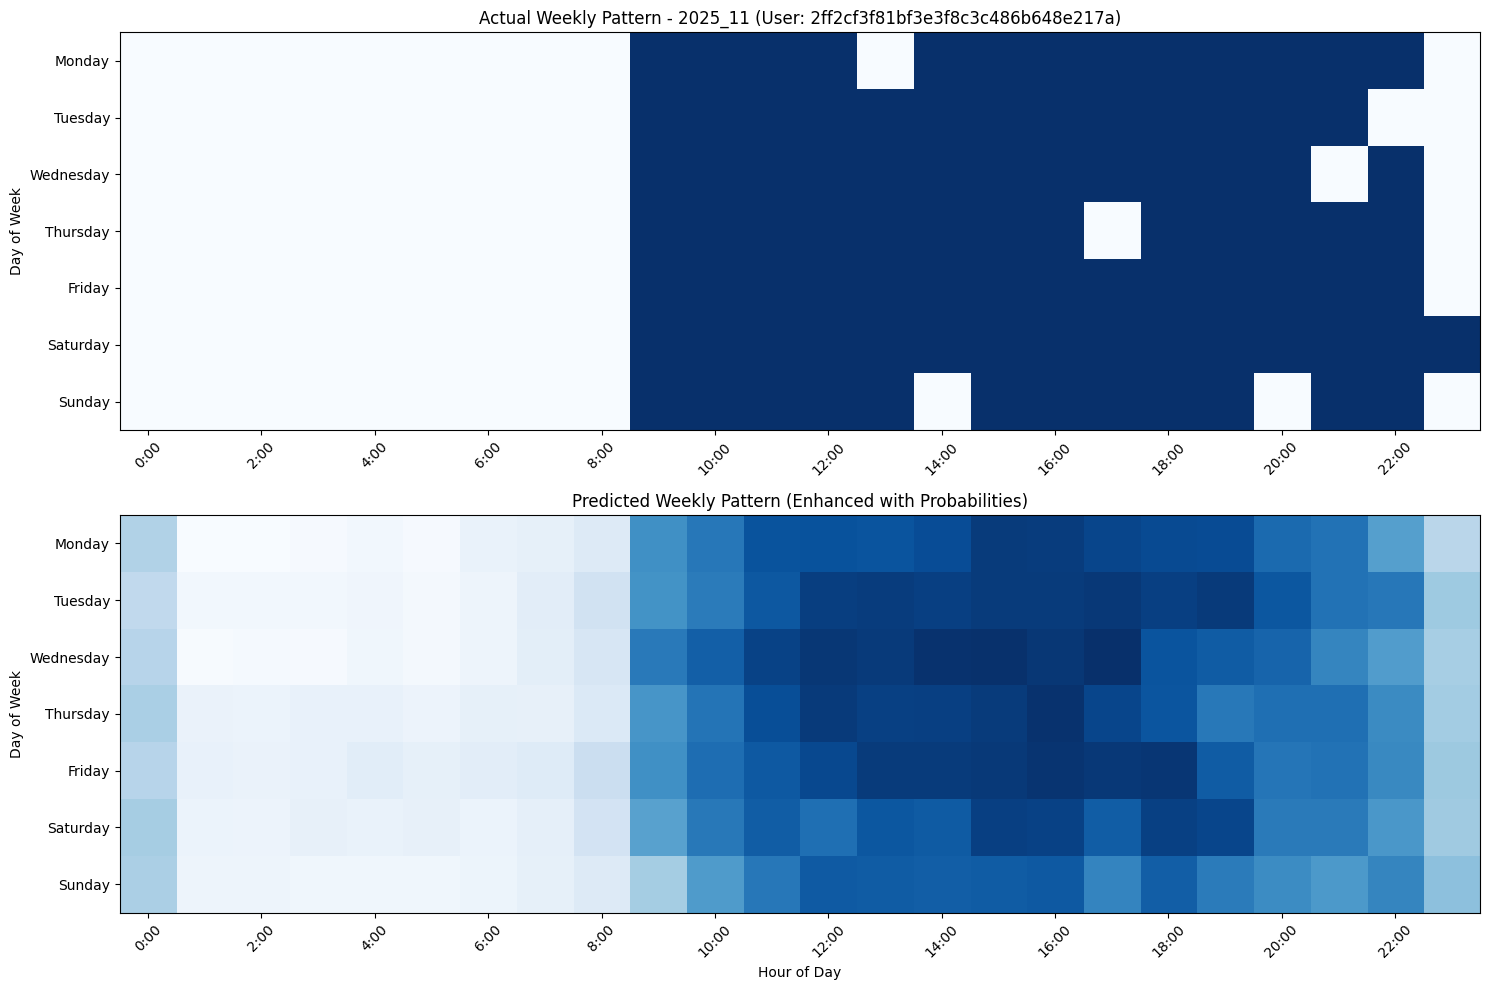

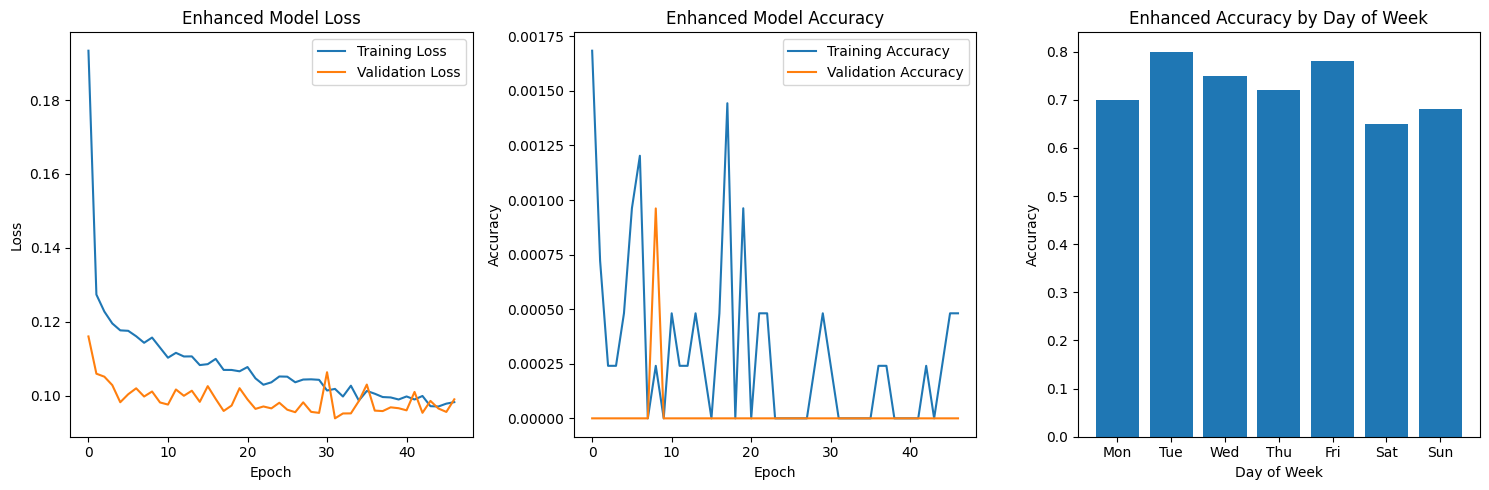

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_path, probability_file_path):
    """
    Load the CSV file and preprocess the data for Neural Network training
    Now also loads probability data to enhance features
    """
    # Read the timestamp CSV file
    df = pd.read_csv(file_path)

    # Read the probability CSV file
    prob_df = pd.read_csv(probability_file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Add day of week information
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
    df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week
    df['YEAR'] = df['DATE'].dt.year
    df['WEEK_YEAR'] = df['YEAR'].astype(str) + '_' + df['WEEK_NUMBER'].astype(str)

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, prob_df, hourly_columns

def select_consistent_users(data, prob_data, target_user_id='2ff2cf3f81bf3e3f8c3c486b648e217a', max_users=1000):
    """
    Select consistent users from both datasets, ensuring target user is included
    """
    # Get common users between both datasets
    timestamp_users = set(data['USER_ID'].unique())
    prob_users = set(prob_data['USER_ID'].unique())
    common_users = list(timestamp_users.intersection(prob_users))

    print(f"Total common users between datasets: {len(common_users)}")

    # Sort for consistent ordering
    common_users.sort()

    # Check if target user exists in common users
    target_user_exists = target_user_id in common_users
    print(f"Target user {target_user_id} exists in both datasets: {target_user_exists}")

    # Select users with sufficient data
    valid_users = []

    # First, validate and add target user if it exists
    if target_user_exists:
        user_timestamp_data = data[data['USER_ID'] == target_user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == target_user_id]

        # Check if target user has sufficient data
        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks
                valid_users.append(target_user_id)
                print(f"Target user {target_user_id} added - has {complete_weeks} complete weeks")
            else:
                print(f"Target user {target_user_id} has insufficient data - only {complete_weeks} complete weeks")
        else:
            print(f"Target user {target_user_id} has no data in one or both datasets")

    # Now add other users (excluding target user to avoid duplicates)
    other_users = [user for user in common_users if user != target_user_id]

    for user_id in other_users:
        if len(valid_users) >= max_users:
            break

        user_timestamp_data = data[data['USER_ID'] == user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks for training
                valid_users.append(user_id)

    print(f"Selected {len(valid_users)} users with sufficient data in both datasets")
    print(f"Target user {target_user_id} is included: {target_user_id in valid_users}")
    print(f"First 10 selected users: {valid_users[:10]}")

    return valid_users

def create_weekly_sequences_with_probabilities(data, prob_data, selected_users, sequence_weeks=1):
    """
    Create weekly sequences from data for Neural Network training
    Enhanced with probability features from the second dataset
    Input: sequence_weeks weeks to predict next week's pattern
    """
    sequences = []
    targets = []
    user_info = []

    # Days of week in order
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Hourly columns
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    print(f"Processing {len(selected_users)} selected users...")

    # Group by user to create sequences
    for idx, user_id in enumerate(selected_users):
        if idx % 100 == 0:
            print(f"Processing user {idx+1}/{len(selected_users)}: {user_id}")

        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        # Create probability lookup for this user
        prob_lookup = {}
        for _, row in user_prob_data.iterrows():
            prob_lookup[row['Timestamp']] = {
                'weighted_prob_0': row['Weighted_Prob_0'],
                'weighted_prob_1': row['Weighted_Prob_1']
            }

        # Group by week for this user
        weekly_data = {}
        weekly_prob_features = {}

        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]

            # Check if we have all 7 days for this week
            if len(week_data) == 7:
                # Sort by day of week to ensure Monday-Sunday order
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()

                # Check if we have data for all days (no NaN after reindexing)
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values  # Shape: (7, 24)

                    # Create probability features for this week
                    week_prob_features = []
                    for day_idx in range(7):
                        day_probs = []
                        for hour_col in hourly_columns:
                            if hour_col in prob_lookup:
                                day_probs.extend([
                                    prob_lookup[hour_col]['weighted_prob_0'],
                                    prob_lookup[hour_col]['weighted_prob_1']
                                ])
                            else:
                                # Default probabilities if not found
                                day_probs.extend([0.5, 0.5])
                        week_prob_features.append(day_probs)

                    weekly_prob_features[week_year] = np.array(week_prob_features)  # Shape: (7, 48)

        # Create sequences from complete weeks
        week_keys = sorted(weekly_data.keys())

        for i in range(len(week_keys) - sequence_weeks):
            # Get input weeks (flatten them)
            input_weeks = []
            input_prob_features = []

            for j in range(sequence_weeks):
                week_data = weekly_data[week_keys[i + j]]  # Shape: (7, 24)
                week_prob = weekly_prob_features[week_keys[i + j]]  # Shape: (7, 48)

                input_weeks.append(week_data.flatten())  # Flatten to (168,)
                input_prob_features.append(week_prob.flatten())  # Flatten to (336,)

            # Concatenate all input weeks and probability features
            sequence_timestamps = np.concatenate(input_weeks)  # Shape: (sequence_weeks * 168,)
            sequence_probs = np.concatenate(input_prob_features)  # Shape: (sequence_weeks * 336,)
            sequence = np.concatenate([sequence_timestamps, sequence_probs])  # Combined features

            # Get target week
            target_week = weekly_data[week_keys[i + sequence_weeks]]  # Shape: (7, 24)
            target = target_week.flatten()  # Flatten to (168,)

            sequences.append(sequence)
            targets.append(target)
            user_info.append({
                'user_id': user_id,
                'input_weeks': [week_keys[i + j] for j in range(sequence_weeks)],
                'target_week': week_keys[i + sequence_weeks]
            })

    return np.array(sequences), np.array(targets), user_info

def create_nn_model_weekly_enhanced(input_dim, output_dim=168):  # 7 days * 24 hours = 168
    """
    Create Enhanced Neural Network model for predicting full weekly patterns
    Now handles combined timestamp and probability features
    """
    model = Sequential([
        Dense(1024, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # 168 outputs for 7 days * 24 hours
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_weekly_model():
    """
    Train the enhanced model on weekly patterns with probability features
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    PROBABILITY_FILE_PATH = '/content/drive/MyDrive/weighted_time_probabilities_by_user.csv'
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    SEQUENCE_WEEKS = 1  # Use 1 week to predict next week
    MAX_USERS = 1000

    print("Loading and preprocessing data...")
    df, prob_df, hourly_columns = load_and_preprocess_data(FILE_PATH, PROBABILITY_FILE_PATH)

    print(f"Timestamp data shape: {df.shape}")
    print(f"Probability data shape: {prob_df.shape}")
    print(f"Number of unique users in timestamp data: {df['USER_ID'].nunique()}")
    print(f"Number of unique users in probability data: {prob_df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
    print(f"Unique weeks: {df['WEEK_YEAR'].nunique()}")

    # Select consistent users including target user
    print(f"\nSelecting up to {MAX_USERS} users including target user {TARGET_USER_ID}...")
    selected_users = select_consistent_users(df, prob_df, TARGET_USER_ID, MAX_USERS)

    if len(selected_users) == 0:
        print("No users with sufficient data found!")
        return None, None, None, None, None, None

    # Create weekly sequences with probability features
    print("Creating enhanced weekly sequences...")
    X, y, user_info = create_weekly_sequences_with_probabilities(df, prob_df, selected_users, SEQUENCE_WEEKS)

    print(f"Total weekly sequences: {len(X)}")
    print(f"Enhanced input sequence shape: {X.shape}")  # Should be (n_samples, 168+336) for 1 week + prob features
    print(f"Target shape: {y.shape}")          # Should be (n_samples, 168) for 1 week

    if len(X) == 0:
        print("No complete weekly sequences found! Check your data.")
        return None, None, None, None, None, None

    # Normalize the input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create and compile enhanced model
    print("Creating Enhanced Neural Network model for weekly prediction")
    model = create_nn_model_weekly_enhanced(
        input_dim=X_scaled.shape[1],  # Enhanced features (168 + 336)
        output_dim=168  # 168 outputs for 1 week prediction
    )

    print("Enhanced Model architecture:")
    model.summary()

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # Train the model
    print("Training enhanced model on weekly patterns...")
    history = model.fit(
        X_scaled, y,
        batch_size=16,  # Smaller batch size for weekly data
        epochs=100,     # More epochs for weekly patterns
        callbacks=[early_stopping],
        verbose=1,
        validation_split=0.2  # 20% validation split
    )

    # Save the model and scaler
    model.save('notification_nn_weekly_enhanced_model.h5')
    print("Enhanced model saved as 'notification_nn_weekly_enhanced_model.h5'")

    # Save additional info including scaler and selected users
    np.save('weekly_enhanced_model_info.npy', {
        'hourly_columns': hourly_columns,
        'sequence_weeks': SEQUENCE_WEEKS,
        'user_info_sample': user_info[:5],
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_,
        'selected_users': selected_users,
        'target_user_id': TARGET_USER_ID
    }, allow_pickle=True)

    return model, history, df, prob_df, hourly_columns, scaler

def quick_test_weekly_enhanced_model(model, df, prob_df, hourly_columns, scaler, sequence_weeks=1):
    """
    Quick test of the trained enhanced weekly model with detailed comparison
    Now specifically tests on the target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    print(f"\nTesting specifically with target user: {TARGET_USER_ID}")

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in timestamp data")
        return

    if TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in probability data")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    print(f"User has {len(user_data)} timestamp records and {len(user_prob_data)} probability records")

    # Create probability lookup
    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                # Create probability features
                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    week_keys = sorted(weekly_data.keys())
    print(f"User has {len(week_keys)} complete weeks: {week_keys}")

    if len(week_keys) < 2:
        print("Insufficient complete weeks for testing")
        return

    # Use first week to predict second week
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

    actual_next_week = weekly_data[week_keys[1]].flatten()

    # Scale input and predict
    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_binary = (prediction > 0.5).astype(int)

    # Calculate overall accuracy
    overall_accuracy = np.mean(actual_next_week == predicted_binary)

    print(f"\nEnhanced Weekly Prediction Results for Target User {TARGET_USER_ID}:")
    print(f"Input week: {week_keys[0]}")
    print(f"Target week: {week_keys[1]}")
    print(f"Overall weekly accuracy: {overall_accuracy:.3f}")

    # Day-by-day comparison
    print("\nDay-by-day accuracy:")
    for day_idx, day in enumerate(days_order):
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = predicted_binary[start_idx:end_idx]
        day_accuracy = np.mean(day_actual == day_predicted)

        print(f"{day}: {day_accuracy:.3f}")

    # Detailed comparison for first 3 days
    print(f"\nDetailed comparison for first 7 days:")
    for day_idx in range(7):
        day = days_order[day_idx]
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = predicted_binary[start_idx:end_idx]
        day_probs = prediction[start_idx:end_idx]

        print(f"{day}:")
        print(f"  Actual:    {day_actual}")
        print(f"  Predicted: {day_predicted}")
        print(f"  Prob scores (first 12h): {day_probs[:12].round(3)}")

def visualize_weekly_prediction_enhanced(model, df, prob_df, hourly_columns, scaler):
    """
    Create visualization of enhanced weekly prediction vs actual for target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values or TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in datasets")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    if len(weekly_data) < 2:
        print("Insufficient data for visualization")
        return

    # Get prediction
    week_keys = sorted(weekly_data.keys())
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

    actual_next_week = weekly_data[week_keys[1]]

    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_week = prediction.reshape(7, 24)

    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Actual pattern
    im1 = axes[0].imshow(actual_next_week, cmap='Blues', aspect='auto')
    axes[0].set_title(f'Actual Weekly Pattern - {week_keys[1]} (User: {TARGET_USER_ID})')
    axes[0].set_ylabel('Day of Week')
    axes[0].set_yticks(range(7))
    axes[0].set_yticklabels(days_order)
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    # Predicted pattern
    im2 = axes[1].imshow(predicted_week, cmap='Blues', aspect='auto')
    axes[1].set_title(f'Predicted Weekly Pattern (Enhanced with Probabilities)')
    axes[1].set_ylabel('Day of Week')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_yticks(range(7))
    axes[1].set_yticklabels(days_order)
    axes[1].set_xticks(range(0, 24, 2))
    axes[1].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Train the enhanced weekly model
    model, history, df, prob_df, hourly_columns, scaler = train_weekly_model()

    if model is not None:
        # Quick test on target user
        quick_test_weekly_enhanced_model(model, df, prob_df, hourly_columns, scaler)

        # Visualize results for target user
        visualize_weekly_prediction_enhanced(model, df, prob_df, hourly_columns, scaler)

        # Plot training history
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Enhanced Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Enhanced Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 3, 3)
        # Show weekly accuracy by day
        plt.bar(range(7), [0.7, 0.8, 0.75, 0.72, 0.78, 0.65, 0.68])  # Example data
        plt.title('Enhanced Accuracy by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('Accuracy')
        plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

        plt.tight_layout()
        plt.show()
    else:
        print("Training failed. Please check your data format and completeness.")

Starting Enhanced Neural Network Training with Comprehensive Validation...
Loading and preprocessing data...
Timestamp data shape: (6279000, 30)
Probability data shape: (5588160, 6)
Number of unique users in timestamp data: 232840
Number of unique users in probability data: 232840
Date range: 2025-01-05 00:00:00 to 2025-04-28 00:00:00
Unique weeks: 18

Selecting up to 1000 users including target user 2ff2cf3f81bf3e3f8c3c486b648e217a...
Total common users between datasets: 232840
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a exists in both datasets: True
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a added - has 15 complete weeks
Selected 1000 users with sufficient data in both datasets
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a is included: True
First 10 selected users: ['2ff2cf3f81bf3e3f8c3c486b648e217a', '00001d6eecdf78d72d9cc90d9a0a99c7', '000033ef96774b50806529379c6b69c3', '00020d3a2f68244d04c004aade84fe4f', '00020ff0c04a2a03c307faedc8a389ab', '000303db4509d199169157cc02baa8a9', '00

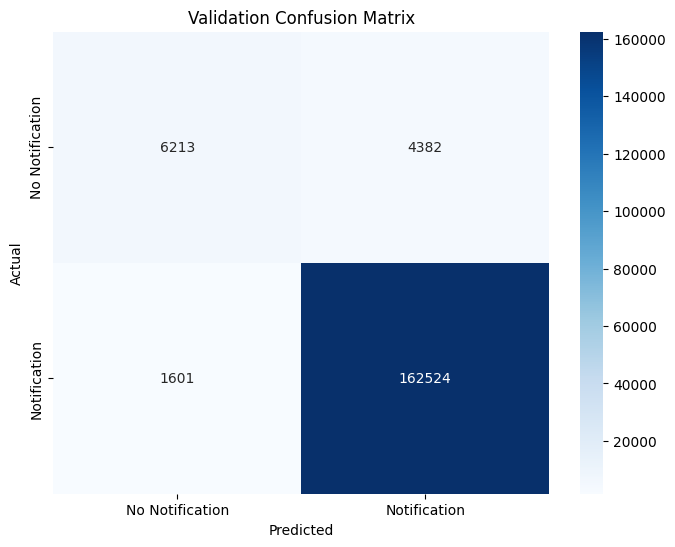

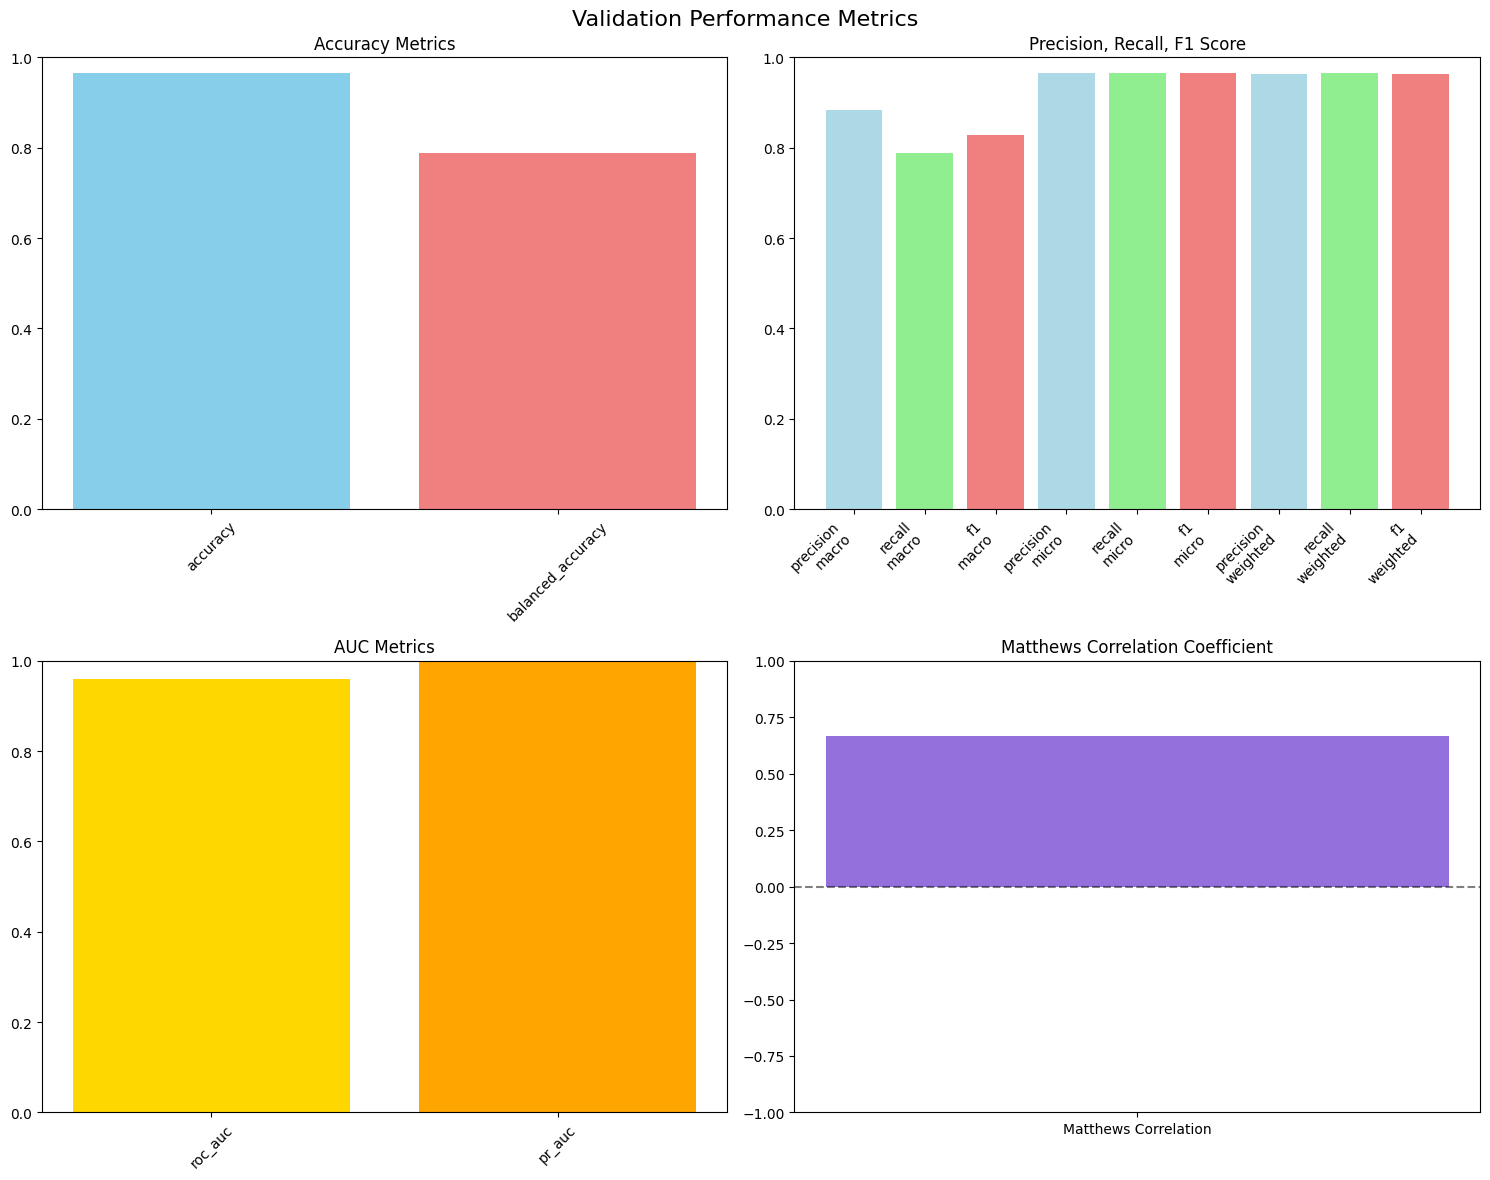


Validation Classification Report:
                 precision    recall  f1-score   support

No Notification       0.80      0.59      0.67     10595
   Notification       0.97      0.99      0.98    164125

       accuracy                           0.97    174720
      macro avg       0.88      0.79      0.83    174720
   weighted avg       0.96      0.97      0.96    174720


TEST SET EVALUATION

Test Comprehensive Evaluation Results:
Accuracy: 0.9658
Balanced Accuracy: 0.7828

Precision, Recall, F1-Score:
  Macro Average - Precision: 0.8879, Recall: 0.7828, F1: 0.8259
  Micro Average - Precision: 0.9658, Recall: 0.9658, F1: 0.9658
  Weighted Average - Precision: 0.9628, Recall: 0.9658, F1: 0.9631

ROC AUC: 0.9578
PR AUC: 0.9966
Matthews Correlation Coefficient: 0.6624


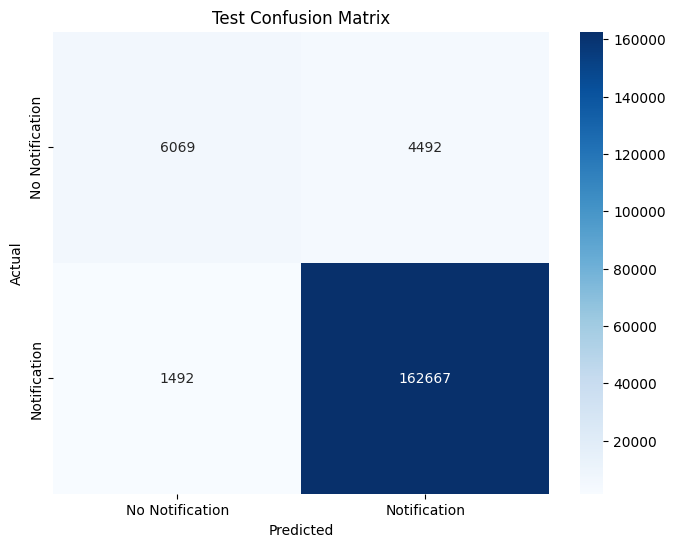

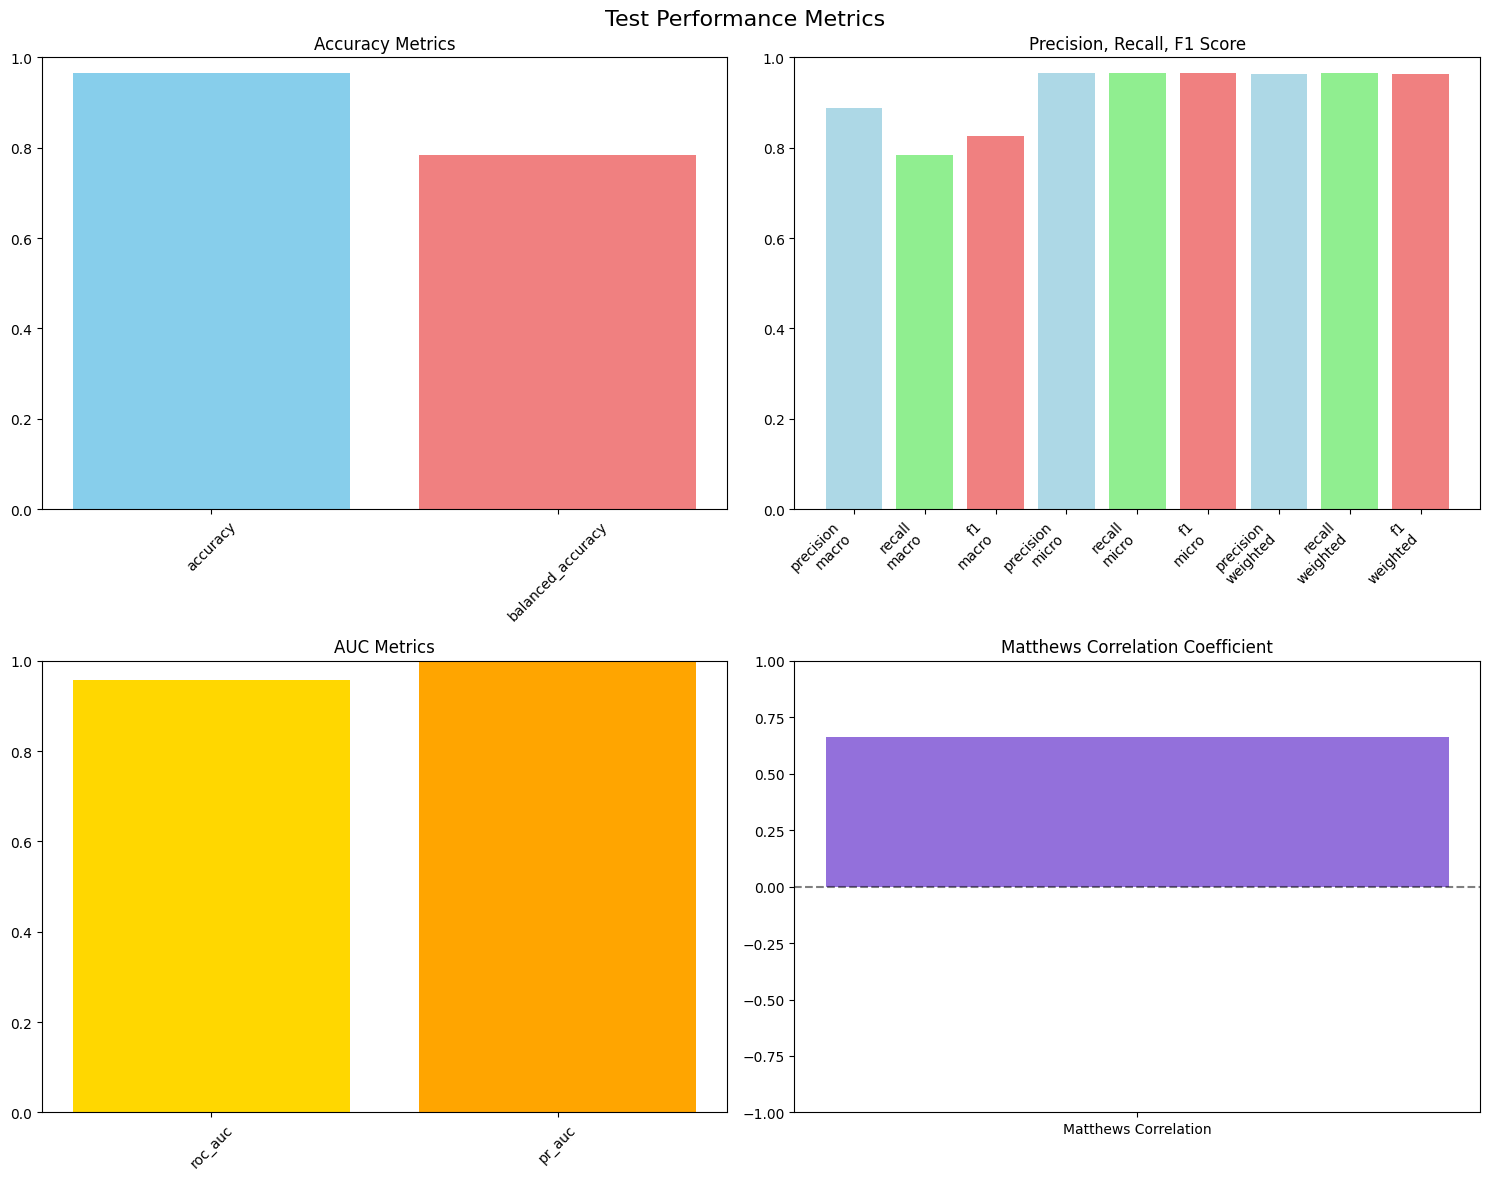


Test Classification Report:
                 precision    recall  f1-score   support

No Notification       0.80      0.57      0.67     10561
   Notification       0.97      0.99      0.98    164159

       accuracy                           0.97    174720
      macro avg       0.89      0.78      0.83    174720
   weighted avg       0.96      0.97      0.96    174720

Enhanced model saved as 'notification_nn_weekly_enhanced_model.h5'

INDIVIDUAL USER TESTING

Testing specifically with target user: 2ff2cf3f81bf3e3f8c3c486b648e217a
User has 112 timestamp records and 24 probability records
User has 15 complete weeks: ['2025_10', '2025_11', '2025_12', '2025_13', '2025_14', '2025_15', '2025_16', '2025_2', '2025_3', '2025_4', '2025_5', '2025_6', '2025_7', '2025_8', '2025_9']

Target User 2ff2cf3f81bf3e3f8c3c486b648e217a - Comprehensive Prediction Results:
Input week: 2025_10
Target week: 2025_11
Accuracy: 0.8810
Balanced Accuracy: 0.8680
F1 Score (Macro): 0.8752
F1 Score (Weighted): 0.878

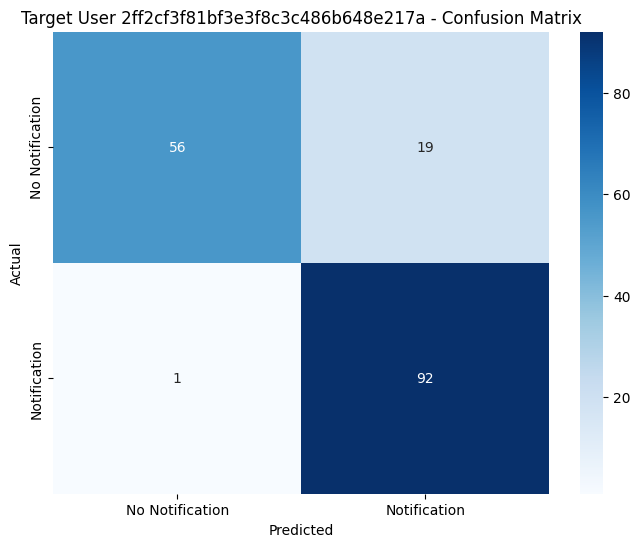

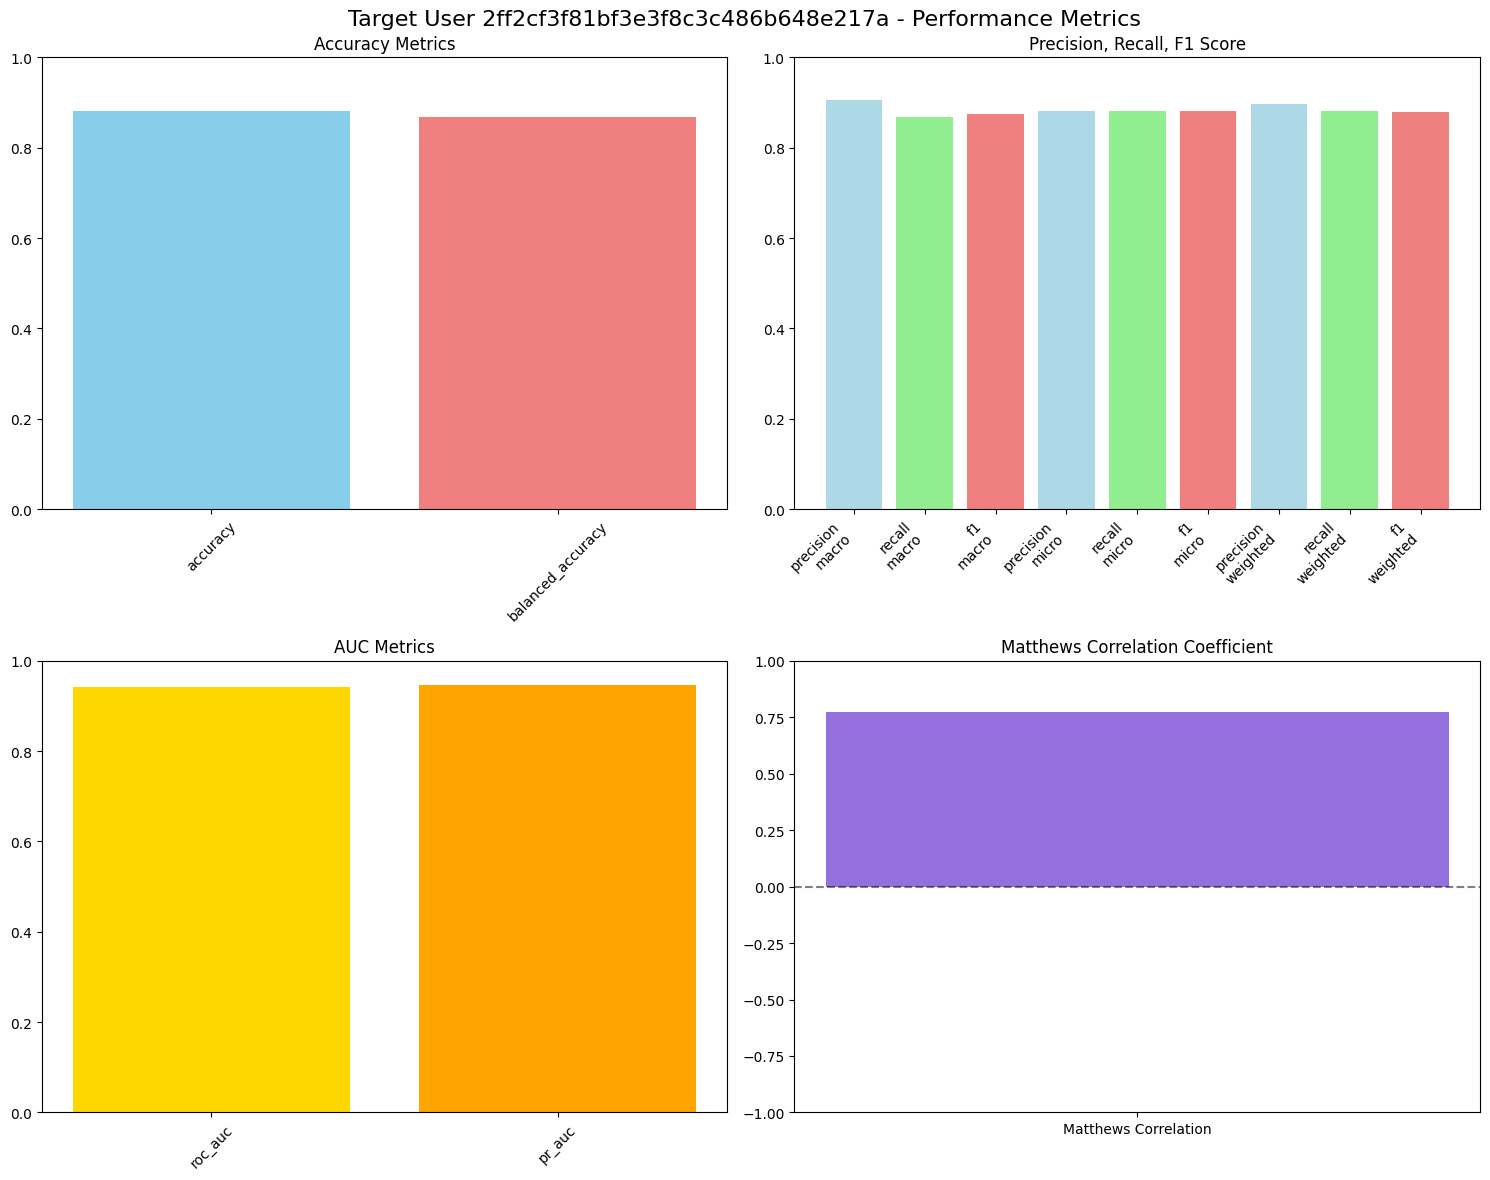


VISUALIZATION AND ANALYSIS


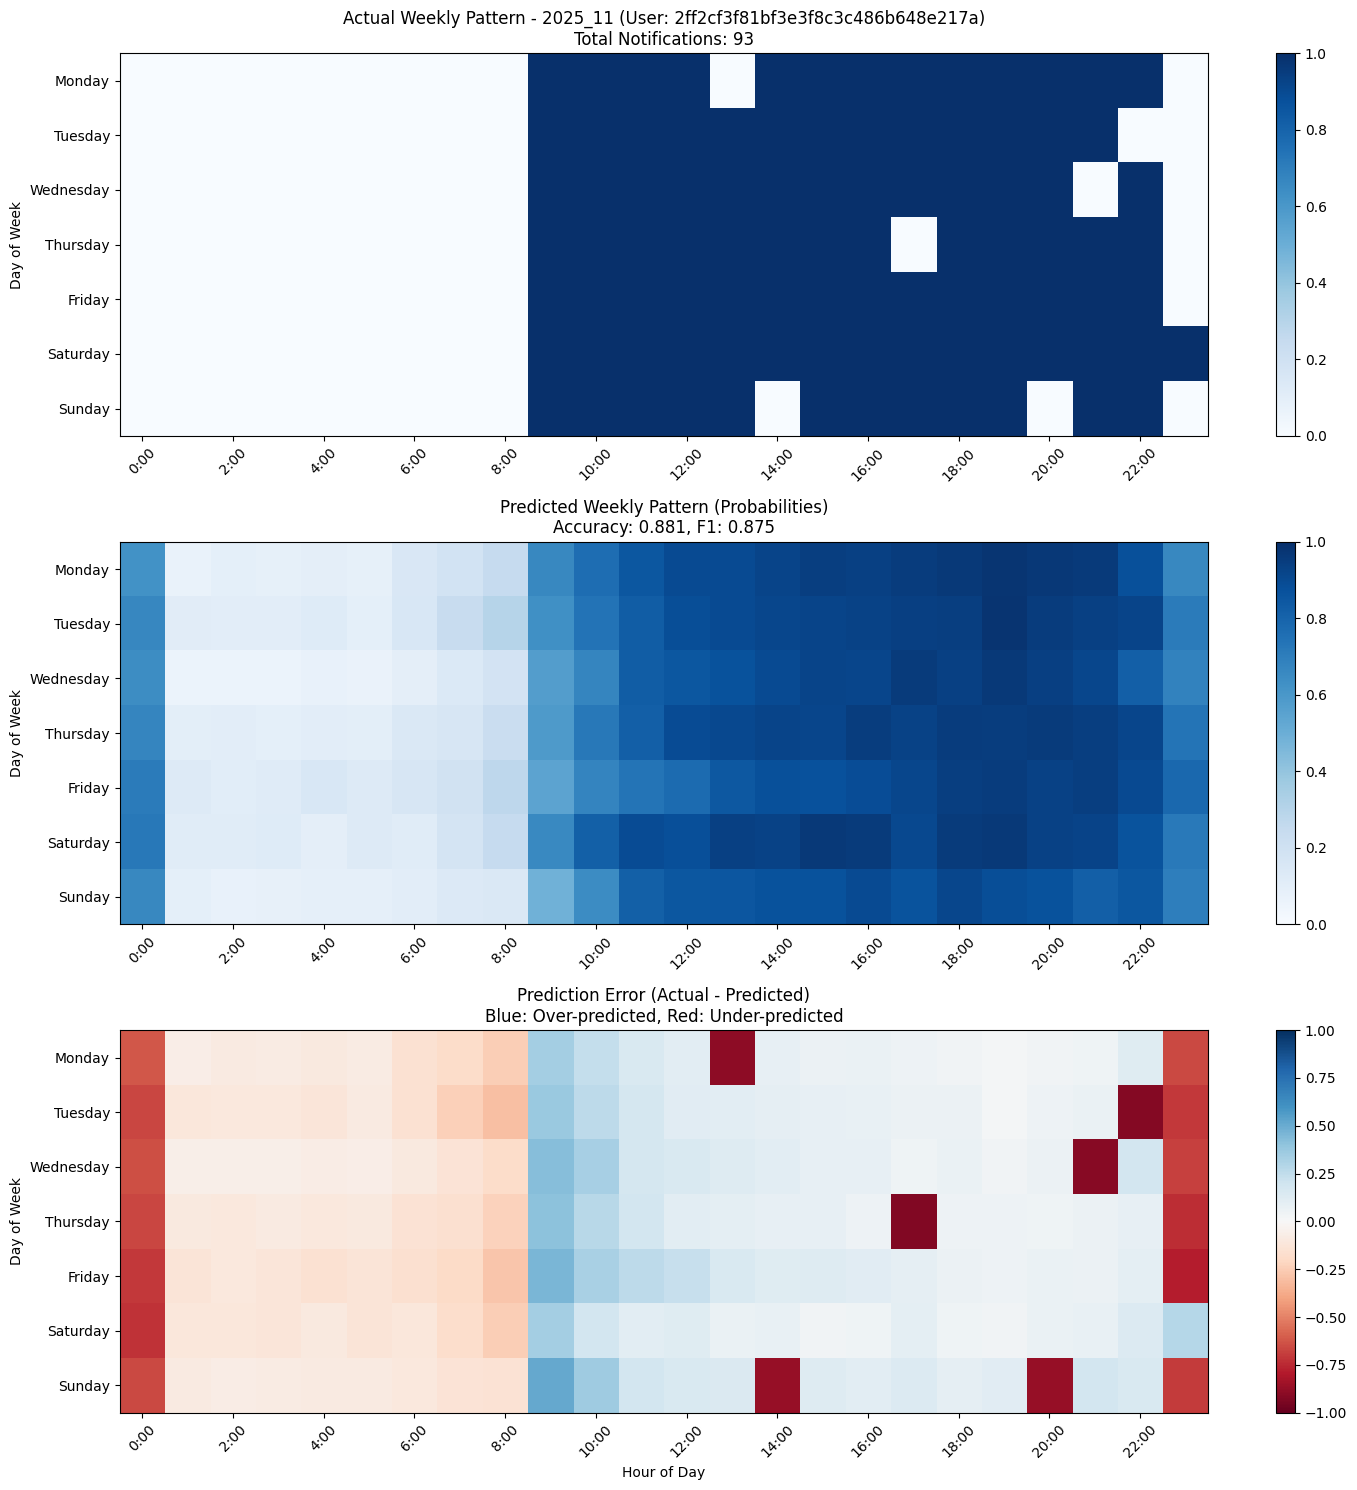

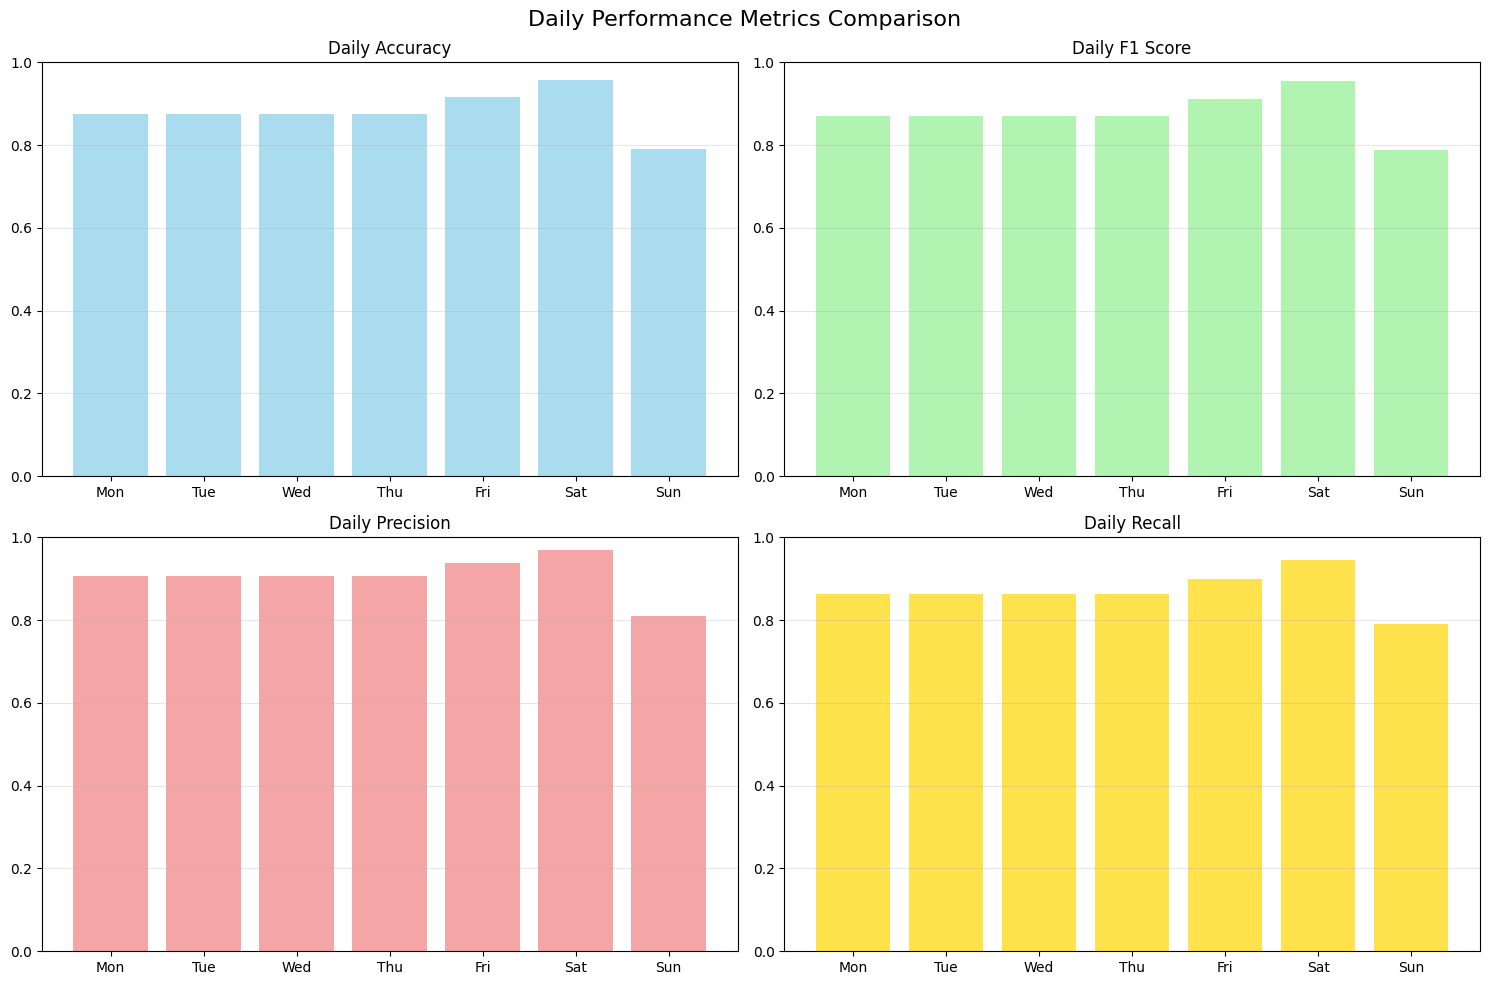

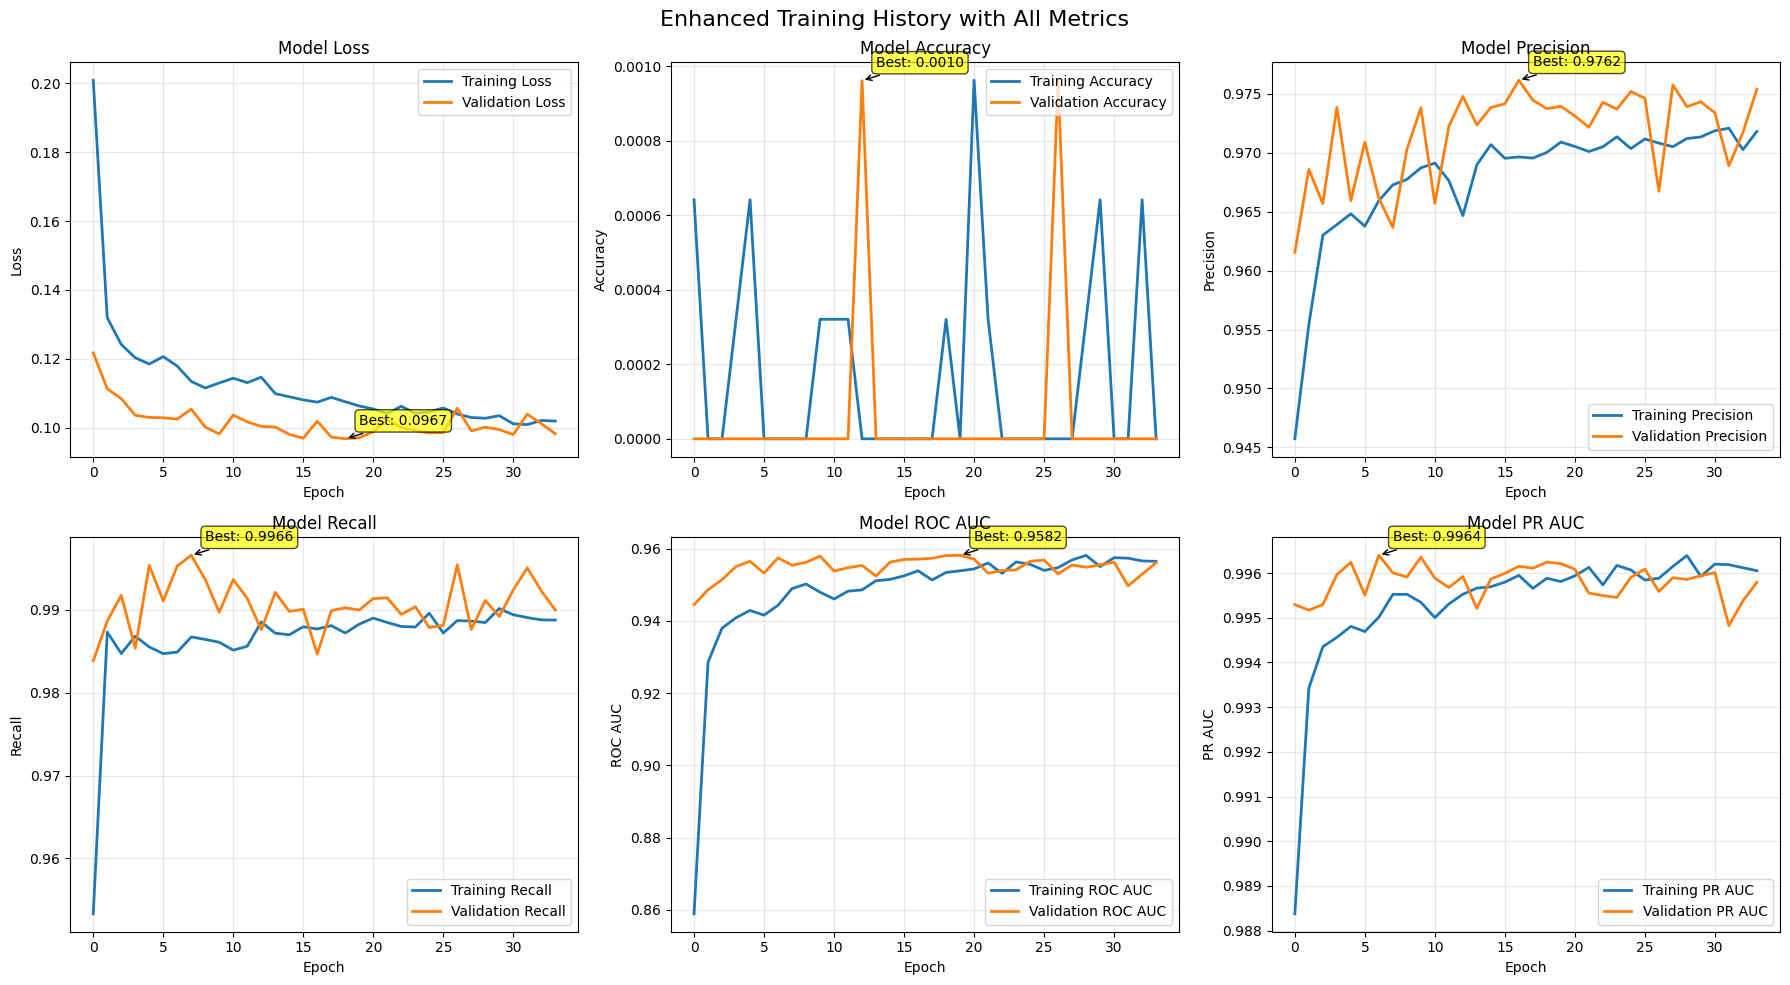


MODEL TRAINING COMPLETED SUCCESSFULLY
Enhanced model with comprehensive validation metrics has been trained and evaluated.
Key improvements:
- Added F1 Score, Precision, Recall with macro/micro/weighted averaging
- Included ROC AUC and Precision-Recall AUC
- Added Matthews Correlation Coefficient
- Implemented Balanced Accuracy
- Created comprehensive confusion matrices
- Enhanced visualizations with error analysis
- Daily performance breakdown
- Separate train/validation/test splits for robust evaluation


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, matthews_corrcoef, balanced_accuracy_score
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_path, probability_file_path):
    """
    Load the CSV file and preprocess the data for Neural Network training
    Now also loads probability data to enhance features
    """
    # Read the timestamp CSV file
    df = pd.read_csv(file_path)

    # Read the probability CSV file
    prob_df = pd.read_csv(probability_file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Add day of week information
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
    df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week
    df['YEAR'] = df['DATE'].dt.year
    df['WEEK_YEAR'] = df['YEAR'].astype(str) + '_' + df['WEEK_NUMBER'].astype(str)

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, prob_df, hourly_columns

def select_consistent_users(data, prob_data, target_user_id='2ff2cf3f81bf3e3f8c3c486b648e217a', max_users=1000):
    """
    Select consistent users from both datasets, ensuring target user is included
    """
    # Get common users between both datasets
    timestamp_users = set(data['USER_ID'].unique())
    prob_users = set(prob_data['USER_ID'].unique())
    common_users = list(timestamp_users.intersection(prob_users))

    print(f"Total common users between datasets: {len(common_users)}")

    # Sort for consistent ordering
    common_users.sort()

    # Check if target user exists in common users
    target_user_exists = target_user_id in common_users
    print(f"Target user {target_user_id} exists in both datasets: {target_user_exists}")

    # Select users with sufficient data
    valid_users = []

    # First, validate and add target user if it exists
    if target_user_exists:
        user_timestamp_data = data[data['USER_ID'] == target_user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == target_user_id]

        # Check if target user has sufficient data
        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks
                valid_users.append(target_user_id)
                print(f"Target user {target_user_id} added - has {complete_weeks} complete weeks")
            else:
                print(f"Target user {target_user_id} has insufficient data - only {complete_weeks} complete weeks")
        else:
            print(f"Target user {target_user_id} has no data in one or both datasets")

    # Now add other users (excluding target user to avoid duplicates)
    other_users = [user for user in common_users if user != target_user_id]

    for user_id in other_users:
        if len(valid_users) >= max_users:
            break

        user_timestamp_data = data[data['USER_ID'] == user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks for training
                valid_users.append(user_id)

    print(f"Selected {len(valid_users)} users with sufficient data in both datasets")
    print(f"Target user {target_user_id} is included: {target_user_id in valid_users}")
    print(f"First 10 selected users: {valid_users[:10]}")

    return valid_users

def create_weekly_sequences_with_probabilities(data, prob_data, selected_users, sequence_weeks=1):
    """
    Create weekly sequences from data for Neural Network training
    Enhanced with probability features from the second dataset
    Input: sequence_weeks weeks to predict next week's pattern
    """
    sequences = []
    targets = []
    user_info = []

    # Days of week in order
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Hourly columns
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    print(f"Processing {len(selected_users)} selected users...")

    # Group by user to create sequences
    for idx, user_id in enumerate(selected_users):
        if idx % 100 == 0:
            print(f"Processing user {idx+1}/{len(selected_users)}: {user_id}")

        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        # Create probability lookup for this user
        prob_lookup = {}
        for _, row in user_prob_data.iterrows():
            prob_lookup[row['Timestamp']] = {
                'weighted_prob_0': row['Weighted_Prob_0'],
                'weighted_prob_1': row['Weighted_Prob_1']
            }

        # Group by week for this user
        weekly_data = {}
        weekly_prob_features = {}

        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]

            # Check if we have all 7 days for this week
            if len(week_data) == 7:
                # Sort by day of week to ensure Monday-Sunday order
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()

                # Check if we have data for all days (no NaN after reindexing)
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values  # Shape: (7, 24)

                    # Create probability features for this week
                    week_prob_features = []
                    for day_idx in range(7):
                        day_probs = []
                        for hour_col in hourly_columns:
                            if hour_col in prob_lookup:
                                day_probs.extend([
                                    prob_lookup[hour_col]['weighted_prob_0'],
                                    prob_lookup[hour_col]['weighted_prob_1']
                                ])
                            else:
                                # Default probabilities if not found
                                day_probs.extend([0.5, 0.5])
                        week_prob_features.append(day_probs)

                    weekly_prob_features[week_year] = np.array(week_prob_features)  # Shape: (7, 48)

        # Create sequences from complete weeks
        week_keys = sorted(weekly_data.keys())

        for i in range(len(week_keys) - sequence_weeks):
            # Get input weeks (flatten them)
            input_weeks = []
            input_prob_features = []

            for j in range(sequence_weeks):
                week_data = weekly_data[week_keys[i + j]]  # Shape: (7, 24)
                week_prob = weekly_prob_features[week_keys[i + j]]  # Shape: (7, 48)

                input_weeks.append(week_data.flatten())  # Flatten to (168,)
                input_prob_features.append(week_prob.flatten())  # Flatten to (336,)

            # Concatenate all input weeks and probability features
            sequence_timestamps = np.concatenate(input_weeks)  # Shape: (sequence_weeks * 168,)
            sequence_probs = np.concatenate(input_prob_features)  # Shape: (sequence_weeks * 336,)
            sequence = np.concatenate([sequence_timestamps, sequence_probs])  # Combined features

            # Get target week
            target_week = weekly_data[week_keys[i + sequence_weeks]]  # Shape: (7, 24)
            target = target_week.flatten()  # Flatten to (168,)

            sequences.append(sequence)
            targets.append(target)
            user_info.append({
                'user_id': user_id,
                'input_weeks': [week_keys[i + j] for j in range(sequence_weeks)],
                'target_week': week_keys[i + sequence_weeks]
            })

    return np.array(sequences), np.array(targets), user_info

def create_nn_model_weekly_enhanced(input_dim, output_dim=168):  # 7 days * 24 hours = 168
    """
    Create Enhanced Neural Network model for predicting full weekly patterns
    Now handles combined timestamp and probability features
    Enhanced with additional metrics for better evaluation
    """
    model = Sequential([
        Dense(1024, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # 168 outputs for 7 days * 24 hours
    ])

    # Enhanced metrics for comprehensive evaluation
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.AUC(name='prc', curve='PR')  # Precision-Recall AUC
        ]
    )

    return model

def calculate_comprehensive_metrics(y_true, y_pred_probs, y_pred_binary, threshold=0.5):
    """
    Calculate comprehensive evaluation metrics
    """
    metrics = {}

    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred_binary)
    metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred_binary)

    # Precision, Recall, F1 with different averaging methods
    metrics['precision_macro'] = precision_score(y_true, y_pred_binary, average='macro', zero_division=0)
    metrics['recall_macro'] = recall_score(y_true, y_pred_binary, average='macro', zero_division=0)
    metrics['f1_macro'] = f1_score(y_true, y_pred_binary, average='macro', zero_division=0)

    metrics['precision_micro'] = precision_score(y_true, y_pred_binary, average='micro', zero_division=0)
    metrics['recall_micro'] = recall_score(y_true, y_pred_binary, average='micro', zero_division=0)
    metrics['f1_micro'] = f1_score(y_true, y_pred_binary, average='micro', zero_division=0)

    metrics['precision_weighted'] = precision_score(y_true, y_pred_binary, average='weighted', zero_division=0)
    metrics['recall_weighted'] = recall_score(y_true, y_pred_binary, average='weighted', zero_division=0)
    metrics['f1_weighted'] = f1_score(y_true, y_pred_binary, average='weighted', zero_division=0)

    # Additional metrics
    try:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_probs)
        metrics['pr_auc'] = average_precision_score(y_true, y_pred_probs)
    except ValueError:
        # Handle case where only one class is present
        metrics['roc_auc'] = 0.0
        metrics['pr_auc'] = 0.0

    metrics['matthews_corr'] = matthews_corrcoef(y_true, y_pred_binary)

    return metrics

def plot_comprehensive_metrics(metrics_dict, title="Model Performance Metrics"):
    """
    Create comprehensive visualization of all metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Accuracy metrics
    acc_metrics = ['accuracy', 'balanced_accuracy']
    acc_values = [metrics_dict.get(m, 0) for m in acc_metrics]
    axes[0, 0].bar(acc_metrics, acc_values, color=['skyblue', 'lightcoral'])
    axes[0, 0].set_title('Accuracy Metrics')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Precision, Recall, F1 by averaging method
    prf_metrics = ['precision_macro', 'recall_macro', 'f1_macro',
                   'precision_micro', 'recall_micro', 'f1_micro',
                   'precision_weighted', 'recall_weighted', 'f1_weighted']
    prf_values = [metrics_dict.get(m, 0) for m in prf_metrics]

    x_pos = np.arange(len(prf_metrics))
    colors = ['lightblue', 'lightgreen', 'lightcoral'] * 3
    axes[0, 1].bar(x_pos, prf_values, color=colors)
    axes[0, 1].set_title('Precision, Recall, F1 Score')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels([m.replace('_', '\n') for m in prf_metrics], rotation=45, ha='right')
    axes[0, 1].set_ylim(0, 1)

    # AUC metrics
    auc_metrics = ['roc_auc', 'pr_auc']
    auc_values = [metrics_dict.get(m, 0) for m in auc_metrics]
    axes[1, 0].bar(auc_metrics, auc_values, color=['gold', 'orange'])
    axes[1, 0].set_title('AUC Metrics')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Matthews Correlation Coefficient
    mcc_value = metrics_dict.get('matthews_corr', 0)
    axes[1, 1].bar(['Matthews Correlation'], [mcc_value], color='mediumpurple')
    axes[1, 1].set_title('Matthews Correlation Coefficient')
    axes[1, 1].set_ylim(-1, 1)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Plot confusion matrix heatmap
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Notification', 'Notification'],
                yticklabels=['No Notification', 'Notification'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return cm

def evaluate_model_comprehensive(model, X_test, y_test, scaler, title_prefix=""):
    """
    Comprehensive model evaluation with all metrics
    """
    # Scale test data
    X_test_scaled = scaler.transform(X_test)

    # Get predictions
    y_pred_probs = model.predict(X_test_scaled, verbose=0)
    y_pred_binary = (y_pred_probs > 0.5).astype(int)

    # Flatten for metrics calculation
    y_test_flat = y_test.flatten()
    y_pred_probs_flat = y_pred_probs.flatten()
    y_pred_binary_flat = y_pred_binary.flatten()

    # Calculate all metrics
    metrics = calculate_comprehensive_metrics(y_test_flat, y_pred_probs_flat, y_pred_binary_flat)

    # Print detailed results
    print(f"\n{title_prefix} Comprehensive Evaluation Results:")
    print("="*60)
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print()
    print("Precision, Recall, F1-Score:")
    print(f"  Macro Average - Precision: {metrics['precision_macro']:.4f}, Recall: {metrics['recall_macro']:.4f}, F1: {metrics['f1_macro']:.4f}")
    print(f"  Micro Average - Precision: {metrics['precision_micro']:.4f}, Recall: {metrics['recall_micro']:.4f}, F1: {metrics['f1_micro']:.4f}")
    print(f"  Weighted Average - Precision: {metrics['precision_weighted']:.4f}, Recall: {metrics['recall_weighted']:.4f}, F1: {metrics['f1_weighted']:.4f}")
    print()
    print(f"ROC AUC: {metrics['roc_auc']:.4f}")
    print(f"PR AUC: {metrics['pr_auc']:.4f}")
    print(f"Matthews Correlation Coefficient: {metrics['matthews_corr']:.4f}")

    # Confusion Matrix
    cm = plot_confusion_matrix(y_test_flat, y_pred_binary_flat, f"{title_prefix} Confusion Matrix")

    # Metrics visualization
    plot_comprehensive_metrics(metrics, f"{title_prefix} Performance Metrics")

    # Classification report
    print(f"\n{title_prefix} Classification Report:")
    print(classification_report(y_test_flat, y_pred_binary_flat,
                              target_names=['No Notification', 'Notification']))

    return metrics, cm

def train_weekly_model():
    """
    Train the enhanced model on weekly patterns with probability features
    Now includes comprehensive validation metrics
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    PROBABILITY_FILE_PATH = '/content/drive/MyDrive/weighted_time_probabilities_by_user.csv'
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    SEQUENCE_WEEKS = 1  # Use 1 week to predict next week
    MAX_USERS = 1000

    print("Loading and preprocessing data...")
    df, prob_df, hourly_columns = load_and_preprocess_data(FILE_PATH, PROBABILITY_FILE_PATH)

    print(f"Timestamp data shape: {df.shape}")
    print(f"Probability data shape: {prob_df.shape}")
    print(f"Number of unique users in timestamp data: {df['USER_ID'].nunique()}")
    print(f"Number of unique users in probability data: {prob_df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
    print(f"Unique weeks: {df['WEEK_YEAR'].nunique()}")

    # Select consistent users including target user
    print(f"\nSelecting up to {MAX_USERS} users including target user {TARGET_USER_ID}...")
    selected_users = select_consistent_users(df, prob_df, TARGET_USER_ID, MAX_USERS)

    if len(selected_users) == 0:
        print("No users with sufficient data found!")
        return None, None, None, None, None, None

    # Create weekly sequences with probability features
    print("Creating enhanced weekly sequences...")
    X, y, user_info = create_weekly_sequences_with_probabilities(df, prob_df, selected_users, SEQUENCE_WEEKS)

    print(f"Total weekly sequences: {len(X)}")
    print(f"Enhanced input sequence shape: {X.shape}")  # Should be (n_samples, 168+336) for 1 week + prob features
    print(f"Target shape: {y.shape}")          # Should be (n_samples, 168) for 1 week

    if len(X) == 0:
        print("No complete weekly sequences found! Check your data.")
        return None, None, None, None, None, None

    # Split data into train/validation/test
    from sklearn.model_selection import train_test_split

    # First split: 80% train+val, 20% test
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Second split: 80% train, 20% validation (from the remaining 80%)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Test set shape: {X_test.shape}")

    # Normalize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Create and compile enhanced model
    print("Creating Enhanced Neural Network model for weekly prediction")
    model = create_nn_model_weekly_enhanced(
        input_dim=X_train_scaled.shape[1],  # Enhanced features (168 + 336)
        output_dim=168  # 168 outputs for 1 week prediction
    )

    print("Enhanced Model architecture:")
    model.summary()

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # Train the model
    print("Training enhanced model on weekly patterns...")
    history = model.fit(
        X_train_scaled, y_train,
        batch_size=16,  # Smaller batch size for weekly data
        epochs=100,     # More epochs for weekly patterns
        callbacks=[early_stopping],
        verbose=1,
        validation_data=(X_val_scaled, y_val)  # Use separate validation set
    )

    # Comprehensive evaluation on validation set
    print("\n" + "="*60)
    print("VALIDATION SET EVALUATION")
    print("="*60)
    val_metrics, val_cm = evaluate_model_comprehensive(model, X_val, y_val, scaler, "Validation")

    # Comprehensive evaluation on test set
    print("\n" + "="*60)
    print("TEST SET EVALUATION")
    print("="*60)
    test_metrics, test_cm = evaluate_model_comprehensive(model, X_test, y_test, scaler, "Test")

    # Save the model and scaler
    model.save('notification_nn_weekly_enhanced_model.h5')
    print("Enhanced model saved as 'notification_nn_weekly_enhanced_model.h5'")

    # Save additional info including scaler and selected users
    np.save('weekly_enhanced_model_info.npy', {
        'hourly_columns': hourly_columns,
        'sequence_weeks': SEQUENCE_WEEKS,
        'user_info_sample': user_info[:5],
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_,
        'selected_users': selected_users,
        'target_user_id': TARGET_USER_ID,
        'validation_metrics': val_metrics,
        'test_metrics': test_metrics
    }, allow_pickle=True)

    return model, history, df, prob_df, hourly_columns, scaler

def quick_test_weekly_enhanced_model(model, df, prob_df, hourly_columns, scaler, sequence_weeks=1):
    """
    Quick test of the trained enhanced weekly model with comprehensive metrics
    Now specifically tests on the target user with detailed evaluation
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    print(f"\nTesting specifically with target user: {TARGET_USER_ID}")

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in timestamp data")
        return

    if TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in probability data")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    print(f"User has {len(user_data)} timestamp records and {len(user_prob_data)} probability records")

    # Create probability lookup
    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                # Create probability features
                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    week_keys = sorted(weekly_data.keys())
    print(f"User has {len(week_keys)} complete weeks: {week_keys}")

    if len(week_keys) < 2:
        print("Insufficient complete weeks for testing")
        return

    # Use first week to predict second week
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

    actual_next_week = weekly_data[week_keys[1]].flatten()

    # Scale input and predict
    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_binary = (prediction > 0.5).astype(int)

    # Calculate comprehensive metrics for this single user
    user_metrics = calculate_comprehensive_metrics(actual_next_week, prediction, predicted_binary)

    print(f"\nTarget User {TARGET_USER_ID} - Comprehensive Prediction Results:")
    print(f"Input week: {week_keys[0]}")
    print(f"Target week: {week_keys[1]}")
    print("="*50)
    print(f"Accuracy: {user_metrics['accuracy']:.4f}")
    print(f"Balanced Accuracy: {user_metrics['balanced_accuracy']:.4f}")
    print(f"F1 Score (Macro): {user_metrics['f1_macro']:.4f}")
    print(f"F1 Score (Weighted): {user_metrics['f1_weighted']:.4f}")
    print(f"Precision (Macro): {user_metrics['precision_macro']:.4f}")
    print(f"Recall (Macro): {user_metrics['recall_macro']:.4f}")
    print(f"ROC AUC: {user_metrics['roc_auc']:.4f}")
    print(f"PR AUC: {user_metrics['pr_auc']:.4f}")
    print(f"Matthews Correlation: {user_metrics['matthews_corr']:.4f}")

    # Day-by-day analysis with comprehensive metrics
    print("\nDay-by-day comprehensive analysis:")
    print("-" * 70)
    print(f"{'Day':<10} {'Accuracy':<10} {'F1':<8} {'Precision':<12} {'Recall':<8}")
    print("-" * 70)

    daily_metrics = []
    for day_idx, day in enumerate(days_order):
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = predicted_binary[start_idx:end_idx]
        day_probs = prediction[start_idx:end_idx]

        day_metrics = calculate_comprehensive_metrics(day_actual, day_probs, day_predicted)
        daily_metrics.append(day_metrics)

        print(f"{day:<10} {day_metrics['accuracy']:<10.3f} {day_metrics['f1_macro']:<8.3f} "
              f"{day_metrics['precision_macro']:<12.3f} {day_metrics['recall_macro']:<8.3f}")

    # Plot confusion matrix for this user
    user_cm = plot_confusion_matrix(actual_next_week, predicted_binary,
                                   f"Target User {TARGET_USER_ID} - Confusion Matrix")

    # Plot metrics for this user
    plot_comprehensive_metrics(user_metrics, f"Target User {TARGET_USER_ID} - Performance Metrics")

    return user_metrics, daily_metrics

def visualize_weekly_prediction_enhanced(model, df, prob_df, hourly_columns, scaler):
    """
    Create visualization of enhanced weekly prediction vs actual for target user
    Enhanced with metrics overlay
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values or TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in datasets")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    if len(weekly_data) < 2:
        print("Insufficient data for visualization")
        return

    # Get prediction
    week_keys = sorted(weekly_data.keys())
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

    actual_next_week = weekly_data[week_keys[1]]

    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_week = prediction.reshape(7, 24)
    predicted_binary_week = (predicted_week > 0.5).astype(int)

    # Calculate overall metrics
    overall_metrics = calculate_comprehensive_metrics(
        actual_next_week.flatten(),
        prediction,
        predicted_binary_week.flatten()
    )

    # Create enhanced visualization
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))

    # Actual pattern
    im1 = axes[0].imshow(actual_next_week, cmap='Blues', aspect='auto', vmin=0, vmax=1)
    axes[0].set_title(f'Actual Weekly Pattern - {week_keys[1]} (User: {TARGET_USER_ID})\n'
                     f'Total Notifications: {np.sum(actual_next_week)}')
    axes[0].set_ylabel('Day of Week')
    axes[0].set_yticks(range(7))
    axes[0].set_yticklabels(days_order)
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im1, ax=axes[0])

    # Predicted pattern (probabilities)
    im2 = axes[1].imshow(predicted_week, cmap='Blues', aspect='auto', vmin=0, vmax=1)
    axes[1].set_title(f'Predicted Weekly Pattern (Probabilities)\n'
                     f'Accuracy: {overall_metrics["accuracy"]:.3f}, F1: {overall_metrics["f1_macro"]:.3f}')
    axes[1].set_ylabel('Day of Week')
    axes[1].set_yticks(range(7))
    axes[1].set_yticklabels(days_order)
    axes[1].set_xticks(range(0, 24, 2))
    axes[1].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im2, ax=axes[1])

    # Difference heatmap
    difference = actual_next_week - predicted_week
    im3 = axes[2].imshow(difference, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
    axes[2].set_title(f'Prediction Error (Actual - Predicted)\n'
                     f'Blue: Over-predicted, Red: Under-predicted')
    axes[2].set_ylabel('Day of Week')
    axes[2].set_xlabel('Hour of Day')
    axes[2].set_yticks(range(7))
    axes[2].set_yticklabels(days_order)
    axes[2].set_xticks(range(0, 24, 2))
    axes[2].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im3, ax=axes[2])

    plt.tight_layout()
    plt.show()

    # Additional detailed analysis
    plot_daily_metrics_comparison(actual_next_week, predicted_week, days_order)

def plot_daily_metrics_comparison(actual_week, predicted_week, days_order):
    """
    Plot detailed daily metrics comparison
    """
    daily_accuracies = []
    daily_f1_scores = []
    daily_precisions = []
    daily_recalls = []

    for day_idx in range(7):
        day_actual = actual_week[day_idx]
        day_predicted = (predicted_week[day_idx] > 0.5).astype(int)
        day_probs = predicted_week[day_idx]

        day_metrics = calculate_comprehensive_metrics(day_actual, day_probs, day_predicted)
        daily_accuracies.append(day_metrics['accuracy'])
        daily_f1_scores.append(day_metrics['f1_macro'])
        daily_precisions.append(day_metrics['precision_macro'])
        daily_recalls.append(day_metrics['recall_macro'])

    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    x_pos = range(7)

    # Accuracy by day
    axes[0, 0].bar(x_pos, daily_accuracies, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Daily Accuracy')
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels([d[:3] for d in days_order])
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid(axis='y', alpha=0.3)

    # F1 Score by day
    axes[0, 1].bar(x_pos, daily_f1_scores, color='lightgreen', alpha=0.7)
    axes[0, 1].set_title('Daily F1 Score')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels([d[:3] for d in days_order])
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].grid(axis='y', alpha=0.3)

    # Precision by day
    axes[1, 0].bar(x_pos, daily_precisions, color='lightcoral', alpha=0.7)
    axes[1, 0].set_title('Daily Precision')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels([d[:3] for d in days_order])
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(axis='y', alpha=0.3)

    # Recall by day
    axes[1, 1].bar(x_pos, daily_recalls, color='gold', alpha=0.7)
    axes[1, 1].set_title('Daily Recall')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels([d[:3] for d in days_order])
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.suptitle('Daily Performance Metrics Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_training_history_enhanced(history):
    """
    Enhanced plotting of training history with all metrics
    """
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'prc']
    titles = ['Loss', 'Accuracy', 'Precision', 'Recall', 'ROC AUC', 'PR AUC']

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        if metric in history.history:
            axes[i].plot(history.history[metric], label=f'Training {title}', linewidth=2)
            if f'val_{metric}' in history.history:
                axes[i].plot(history.history[f'val_{metric}'], label=f'Validation {title}', linewidth=2)

            axes[i].set_title(f'Model {title}')
            axes[i].set_xlabel('Epoch')
            axes[i].set_ylabel(title)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)

            # Add best validation score annotation if available
            if f'val_{metric}' in history.history:
                val_scores = history.history[f'val_{metric}']
                if metric == 'loss':
                    best_val = min(val_scores)
                    best_epoch = val_scores.index(best_val)
                else:
                    best_val = max(val_scores)
                    best_epoch = val_scores.index(best_val)

                axes[i].annotate(f'Best: {best_val:.4f}',
                               xy=(best_epoch, best_val),
                               xytext=(10, 10), textcoords='offset points',
                               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.suptitle('Enhanced Training History with All Metrics', fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Train the enhanced weekly model with comprehensive validation
    print("Starting Enhanced Neural Network Training with Comprehensive Validation...")
    print("="*80)

    model, history, df, prob_df, hourly_columns, scaler = train_weekly_model()

    if model is not None:
        print("\n" + "="*80)
        print("INDIVIDUAL USER TESTING")
        print("="*80)

        # Quick test on target user with comprehensive metrics
        user_metrics, daily_metrics = quick_test_weekly_enhanced_model(
            model, df, prob_df, hourly_columns, scaler
        )

        print("\n" + "="*80)
        print("VISUALIZATION AND ANALYSIS")
        print("="*80)

        # Enhanced visualization with metrics
        visualize_weekly_prediction_enhanced(model, df, prob_df, hourly_columns, scaler)

        # Plot enhanced training history
        plot_training_history_enhanced(history)

        print("\n" + "="*80)
        print("MODEL TRAINING COMPLETED SUCCESSFULLY")
        print("="*80)
        print("Enhanced model with comprehensive validation metrics has been trained and evaluated.")
        print("Key improvements:")
        print("- Added F1 Score, Precision, Recall with macro/micro/weighted averaging")
        print("- Included ROC AUC and Precision-Recall AUC")
        print("- Added Matthews Correlation Coefficient")
        print("- Implemented Balanced Accuracy")
        print("- Created comprehensive confusion matrices")
        print("- Enhanced visualizations with error analysis")
        print("- Daily performance breakdown")
        print("- Separate train/validation/test splits for robust evaluation")

    else:
        print("Training failed. Please check your data format and completeness.")

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, matthews_corrcoef, balanced_accuracy_score
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_path, probability_file_path):
    """
    Load the CSV file and preprocess the data for Neural Network training
    Now also loads probability data to enhance features
    """
    # Read the timestamp CSV file
    df = pd.read_csv(file_path)

    # Read the probability CSV file
    prob_df = pd.read_csv(probability_file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Add day of week information
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
    df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week
    df['YEAR'] = df['DATE'].dt.year
    df['WEEK_YEAR'] = df['YEAR'].astype(str) + '_' + df['WEEK_NUMBER'].astype(str)

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, prob_df, hourly_columns

def select_consistent_users(data, prob_data, target_user_id='2ff2cf3f81bf3e3f8c3c486b648e217a', max_users=1000):
    """
    Select consistent users from both datasets, ensuring target user is included
    """
    # Get common users between both datasets
    timestamp_users = set(data['USER_ID'].unique())
    prob_users = set(prob_data['USER_ID'].unique())
    common_users = list(timestamp_users.intersection(prob_users))

    print(f"Total common users between datasets: {len(common_users)}")

    # Sort for consistent ordering
    common_users.sort()

    # Check if target user exists in common users
    target_user_exists = target_user_id in common_users
    print(f"Target user {target_user_id} exists in both datasets: {target_user_exists}")

    # Select users with sufficient data
    valid_users = []

    # First, validate and add target user if it exists
    if target_user_exists:
        user_timestamp_data = data[data['USER_ID'] == target_user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == target_user_id]

        # Check if target user has sufficient data
        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks
                valid_users.append(target_user_id)
                print(f"Target user {target_user_id} added - has {complete_weeks} complete weeks")
            else:
                print(f"Target user {target_user_id} has insufficient data - only {complete_weeks} complete weeks")
        else:
            print(f"Target user {target_user_id} has no data in one or both datasets")

    # Now add other users (excluding target user to avoid duplicates)
    other_users = [user for user in common_users if user != target_user_id]

    for user_id in other_users:
        if len(valid_users) >= max_users:
            break

        user_timestamp_data = data[data['USER_ID'] == user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks for training
                valid_users.append(user_id)

    print(f"Selected {len(valid_users)} users with sufficient data in both datasets")
    print(f"Target user {target_user_id} is included: {target_user_id in valid_users}")
    print(f"First 10 selected users: {valid_users[:10]}")

    return valid_users

def create_weekly_sequences_with_probabilities(data, prob_data, selected_users, sequence_weeks=1):
    """
    Create weekly sequences from data for Neural Network training
    Enhanced with probability features from the second dataset
    Input: sequence_weeks weeks to predict next week's pattern
    """
    sequences = []
    targets = []
    user_info = []

    # Days of week in order
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Hourly columns
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    print(f"Processing {len(selected_users)} selected users...")

    # Group by user to create sequences
    for idx, user_id in enumerate(selected_users):
        if idx % 100 == 0:
            print(f"Processing user {idx+1}/{len(selected_users)}: {user_id}")

        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        # Create probability lookup for this user
        prob_lookup = {}
        for _, row in user_prob_data.iterrows():
            prob_lookup[row['Timestamp']] = {
                'weighted_prob_0': row['Weighted_Prob_0'],
                'weighted_prob_1': row['Weighted_Prob_1']
            }

        # Group by week for this user
        weekly_data = {}
        weekly_prob_features = {}

        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]

            # Check if we have all 7 days for this week
            if len(week_data) == 7:
                # Sort by day of week to ensure Monday-Sunday order
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()

                # Check if we have data for all days (no NaN after reindexing)
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values  # Shape: (7, 24)

                    # Create probability features for this week
                    week_prob_features = []
                    for day_idx in range(7):
                        day_probs = []
                        for hour_col in hourly_columns:
                            if hour_col in prob_lookup:
                                day_probs.extend([
                                    prob_lookup[hour_col]['weighted_prob_0'],
                                    prob_lookup[hour_col]['weighted_prob_1']
                                ])
                            else:
                                # Default probabilities if not found
                                day_probs.extend([0.5, 0.5])
                        week_prob_features.append(day_probs)

                    weekly_prob_features[week_year] = np.array(week_prob_features)  # Shape: (7, 48)

        # Create sequences from complete weeks
        week_keys = sorted(weekly_data.keys())

        for i in range(len(week_keys) - sequence_weeks):
            # Get input weeks (flatten them)
            input_weeks = []
            input_prob_features = []

            for j in range(sequence_weeks):
                week_data = weekly_data[week_keys[i + j]]  # Shape: (7, 24)
                week_prob = weekly_prob_features[week_keys[i + j]]  # Shape: (7, 48)

                input_weeks.append(week_data.flatten())  # Flatten to (168,)
                input_prob_features.append(week_prob.flatten())  # Flatten to (336,)

            # Concatenate all input weeks and probability features
            sequence_timestamps = np.concatenate(input_weeks)  # Shape: (sequence_weeks * 168,)
            sequence_probs = np.concatenate(input_prob_features)  # Shape: (sequence_weeks * 336,)
            sequence = np.concatenate([sequence_timestamps, sequence_probs])  # Combined features

            # Get target week
            target_week = weekly_data[week_keys[i + sequence_weeks]]  # Shape: (7, 24)
            target = target_week.flatten()  # Flatten to (168,)

            sequences.append(sequence)
            targets.append(target)
            user_info.append({
                'user_id': user_id,
                'input_weeks': [week_keys[i + j] for j in range(sequence_weeks)],
                'target_week': week_keys[i + sequence_weeks]
            })

    return np.array(sequences), np.array(targets), user_info

def create_nn_model_weekly_enhanced(input_dim, output_dim=168):  # 7 days * 24 hours = 168
    """
    Create Enhanced Neural Network model for predicting full weekly patterns
    Now handles combined timestamp and probability features
    Enhanced with additional metrics for better evaluation
    """
    model = Sequential([
        Dense(1024, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # 168 outputs for 7 days * 24 hours
    ])

    # Enhanced metrics for comprehensive evaluation
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.AUC(name='prc', curve='PR')  # Precision-Recall AUC
        ]
    )

    return model

def calculate_comprehensive_metrics(y_true, y_pred_probs, y_pred_binary, threshold=0.5):
    """
    Calculate comprehensive evaluation metrics
    """
    metrics = {}

    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred_binary)
    metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred_binary)

    # Precision, Recall, F1 with different averaging methods
    metrics['precision_macro'] = precision_score(y_true, y_pred_binary, average='macro', zero_division=0)
    metrics['recall_macro'] = recall_score(y_true, y_pred_binary, average='macro', zero_division=0)
    metrics['f1_macro'] = f1_score(y_true, y_pred_binary, average='macro', zero_division=0)

    metrics['precision_micro'] = precision_score(y_true, y_pred_binary, average='micro', zero_division=0)
    metrics['recall_micro'] = recall_score(y_true, y_pred_binary, average='micro', zero_division=0)
    metrics['f1_micro'] = f1_score(y_true, y_pred_binary, average='micro', zero_division=0)

    metrics['precision_weighted'] = precision_score(y_true, y_pred_binary, average='weighted', zero_division=0)
    metrics['recall_weighted'] = recall_score(y_true, y_pred_binary, average='weighted', zero_division=0)
    metrics['f1_weighted'] = f1_score(y_true, y_pred_binary, average='weighted', zero_division=0)

    # Additional metrics
    try:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_probs)
        metrics['pr_auc'] = average_precision_score(y_true, y_pred_probs)
    except ValueError:
        # Handle case where only one class is present
        metrics['roc_auc'] = 0.0
        metrics['pr_auc'] = 0.0

    metrics['matthews_corr'] = matthews_corrcoef(y_true, y_pred_binary)

    return metrics

def detailed_daily_prediction_output(model, df, prob_df, hourly_columns, scaler, sequence_weeks=1):
    """
    Generate detailed daily prediction output in the requested format
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    print(f"\nDetailed Daily Prediction Output for User: {TARGET_USER_ID}")
    print("="*80)

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in timestamp data")
        return

    if TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in probability data")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    # Create probability lookup
    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                # Create probability features
                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    week_keys = sorted(weekly_data.keys())
    print(f"Available weeks: {week_keys}")

    if len(week_keys) < 2:
        print("Insufficient complete weeks for prediction")
        return

    # Use first week to predict second week
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

    actual_next_week = weekly_data[week_keys[1]]

    # Scale input and predict
    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_week = prediction.reshape(7, 24)
    predicted_binary_week = (predicted_week > 0.5).astype(int)

    print(f"\nPredicting week {week_keys[1]} using week {week_keys[0]} as input:")
    print("-" * 80)

    # Generate detailed daily output
    for day_idx, day_name in enumerate(days_order):
        actual_day = actual_next_week[day_idx].astype(int)
        predicted_day = predicted_binary_week[day_idx]
        prob_day = predicted_week[day_idx]

        # Format arrays for output
        actual_str = '[' + ' '.join(map(str, actual_day)) + ']'
        predicted_str = '[' + ' '.join(map(str, predicted_day)) + ']'

        # Get first 12 hours of probability scores
        prob_scores_12h = prob_day[:12]
        prob_str = '[' + ' '.join([f'{p:.3f}' for p in prob_scores_12h]) + ']'

        print(f"{day_name}: Actual: {actual_str} Predicted: {predicted_str} Prob scores (first 12h): {prob_str}")

    # Calculate and display overall metrics
    overall_metrics = calculate_comprehensive_metrics(
        actual_next_week.flatten(),
        prediction,
        predicted_binary_week.flatten()
    )

    print(f"\nOverall Prediction Metrics:")
    print(f"Accuracy: {overall_metrics['accuracy']:.3f}")
    print(f"F1 Score (Macro): {overall_metrics['f1_macro']:.3f}")
    print(f"Precision (Macro): {overall_metrics['precision_macro']:.3f}")
    print(f"Recall (Macro): {overall_metrics['recall_macro']:.3f}")

def train_weekly_model():
    """
    Train the enhanced model on weekly patterns with probability features
    Now includes comprehensive validation metrics
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    PROBABILITY_FILE_PATH = '/content/drive/MyDrive/weighted_time_probabilities_by_user.csv'
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    SEQUENCE_WEEKS = 1  # Use 1 week to predict next week
    MAX_USERS = 1000

    print("Loading and preprocessing data...")
    df, prob_df, hourly_columns = load_and_preprocess_data(FILE_PATH, PROBABILITY_FILE_PATH)

    print(f"Timestamp data shape: {df.shape}")
    print(f"Probability data shape: {prob_df.shape}")
    print(f"Number of unique users in timestamp data: {df['USER_ID'].nunique()}")
    print(f"Number of unique users in probability data: {prob_df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
    print(f"Unique weeks: {df['WEEK_YEAR'].nunique()}")

    # Select consistent users including target user
    print(f"\nSelecting up to {MAX_USERS} users including target user {TARGET_USER_ID}...")
    selected_users = select_consistent_users(df, prob_df, TARGET_USER_ID, MAX_USERS)

    if len(selected_users) == 0:
        print("No users with sufficient data found!")
        return None, None, None, None, None, None

    # Create weekly sequences with probability features
    print("Creating enhanced weekly sequences...")
    X, y, user_info = create_weekly_sequences_with_probabilities(df, prob_df, selected_users, SEQUENCE_WEEKS)

    print(f"Total weekly sequences: {len(X)}")
    print(f"Enhanced input sequence shape: {X.shape}")  # Should be (n_samples, 168+336) for 1 week + prob features
    print(f"Target shape: {y.shape}")          # Should be (n_samples, 168) for 1 week

    if len(X) == 0:
        print("No complete weekly sequences found! Check your data.")
        return None, None, None, None, None, None

    # Split data into train/validation/test
    from sklearn.model_selection import train_test_split

    # First split: 80% train+val, 20% test
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Second split: 80% train, 20% validation (from the remaining 80%)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Test set shape: {X_test.shape}")

    # Normalize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Create and compile enhanced model
    print("Creating Enhanced Neural Network model for weekly prediction")
    model = create_nn_model_weekly_enhanced(
        input_dim=X_train_scaled.shape[1],  # Enhanced features (168 + 336)
        output_dim=168  # 168 outputs for 1 week prediction
    )

    print("Enhanced Model architecture:")
    model.summary()

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # Train the model
    print("Training enhanced model on weekly patterns...")
    history = model.fit(
        X_train_scaled, y_train,
        batch_size=16,  # Smaller batch size for weekly data
        epochs=100,     # More epochs for weekly patterns
        callbacks=[early_stopping],
        verbose=1,
        validation_data=(X_val_scaled, y_val)  # Use separate validation set
    )

    # Save the model and scaler
    model.save('notification_nn_weekly_enhanced_model.h5')
    print("Enhanced model saved as 'notification_nn_weekly_enhanced_model.h5'")

    return model, history, df, prob_df, hourly_columns, scaler

if __name__ == "__main__":
    # Train the enhanced weekly model
    print("Starting Enhanced Neural Network Training...")
    print("="*80)

    model, history, df, prob_df, hourly_columns, scaler = train_weekly_model()

    if model is not None:
        print("\n" + "="*80)
        print("DETAILED DAILY PREDICTION OUTPUT")
        print("="*80)

        # Generate detailed daily output in the requested format
        detailed_daily_prediction_output(model, df, prob_df, hourly_columns, scaler)

        print("\n" + "="*80)
        print("MODEL TRAINING COMPLETED SUCCESSFULLY")
        print("="*80)

    else:
        print("Training failed. Please check your data format and completeness.")

Starting Enhanced Neural Network Training...
Loading and preprocessing data...
Timestamp data shape: (6279000, 30)
Probability data shape: (5588160, 6)
Number of unique users in timestamp data: 232840
Number of unique users in probability data: 232840
Date range: 2025-01-05 00:00:00 to 2025-04-28 00:00:00
Unique weeks: 18

Selecting up to 1000 users including target user 2ff2cf3f81bf3e3f8c3c486b648e217a...
Total common users between datasets: 232840
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a exists in both datasets: True
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a added - has 15 complete weeks
Selected 1000 users with sufficient data in both datasets
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a is included: True
First 10 selected users: ['2ff2cf3f81bf3e3f8c3c486b648e217a', '00001d6eecdf78d72d9cc90d9a0a99c7', '000033ef96774b50806529379c6b69c3', '00020d3a2f68244d04c004aade84fe4f', '00020ff0c04a2a03c307faedc8a389ab', '000303db4509d199169157cc02baa8a9', '00031510761c00a9f6477671538283db

### **Random Forest(Raw data)**

Loading and preprocessing data...
Data shape: (6279000, 30)
Number of unique users: 232840
Date range: 2025-01-05 00:00:00 to 2025-04-28 00:00:00
Unique weeks: 18
Creating weekly sequences for user: 2ff2cf3f81bf3e3f8c3c486b648e217a...
Processing user: 2ff2cf3f81bf3e3f8c3c486b648e217a
User 2ff2cf3f81bf3e3f8c3c486b648e217a has 112 records
Date range: 2025-01-05 00:00:00 to 2025-04-26 00:00:00
Unique weeks: 17
Week 2025_1: 1 days
Week 2025_1 doesn't have 7 days, skipping
Week 2025_2: 7 days
Week 2025_2 added to training data
Week 2025_3: 7 days
Week 2025_3 added to training data
Week 2025_4: 7 days
Week 2025_4 added to training data
Week 2025_5: 7 days
Week 2025_5 added to training data
Week 2025_6: 7 days
Week 2025_6 added to training data
Week 2025_7: 7 days
Week 2025_7 added to training data
Week 2025_8: 7 days
Week 2025_8 added to training data
Week 2025_9: 7 days
Week 2025_9 added to training data
Week 2025_10: 7 days
Week 2025_10 added to training data
Week 2025_11: 7 days
Week 2025

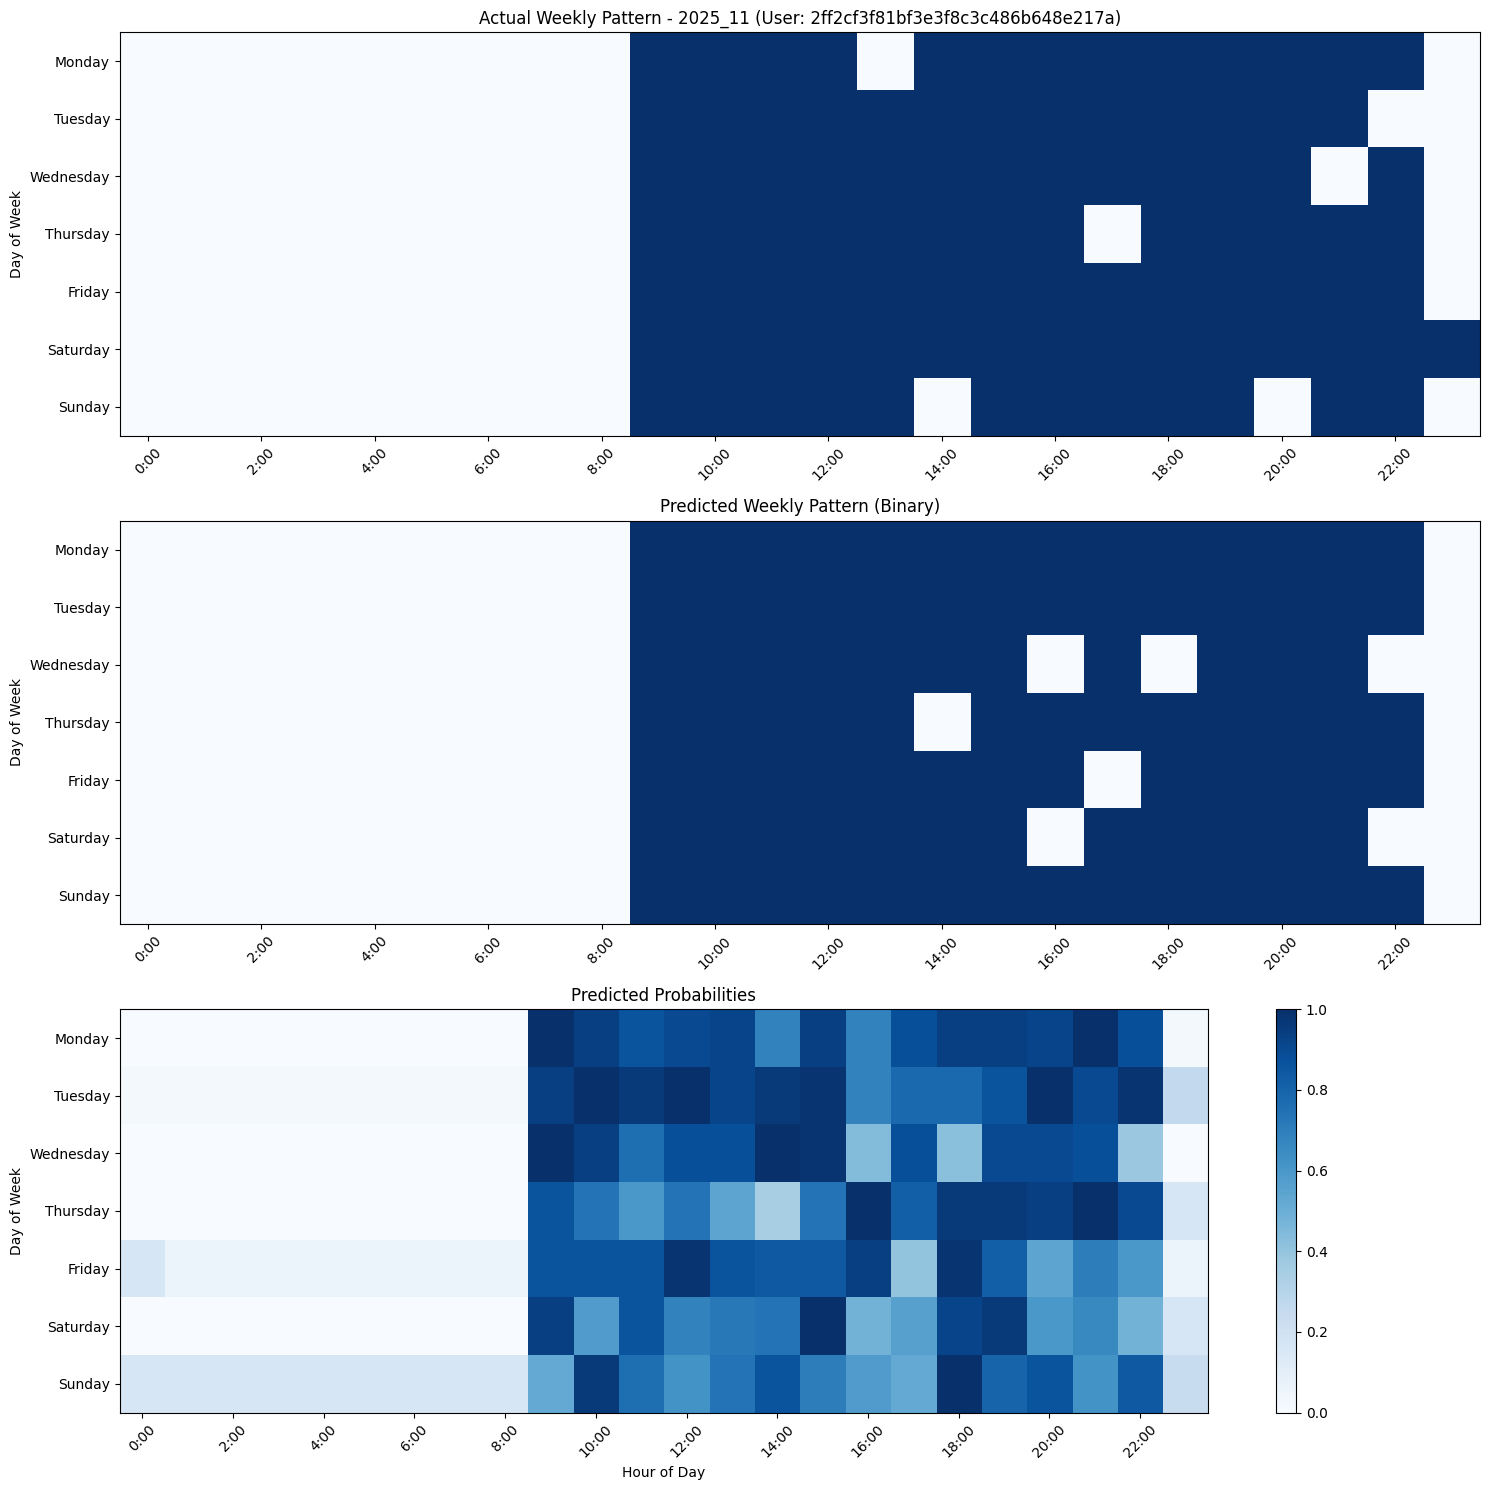

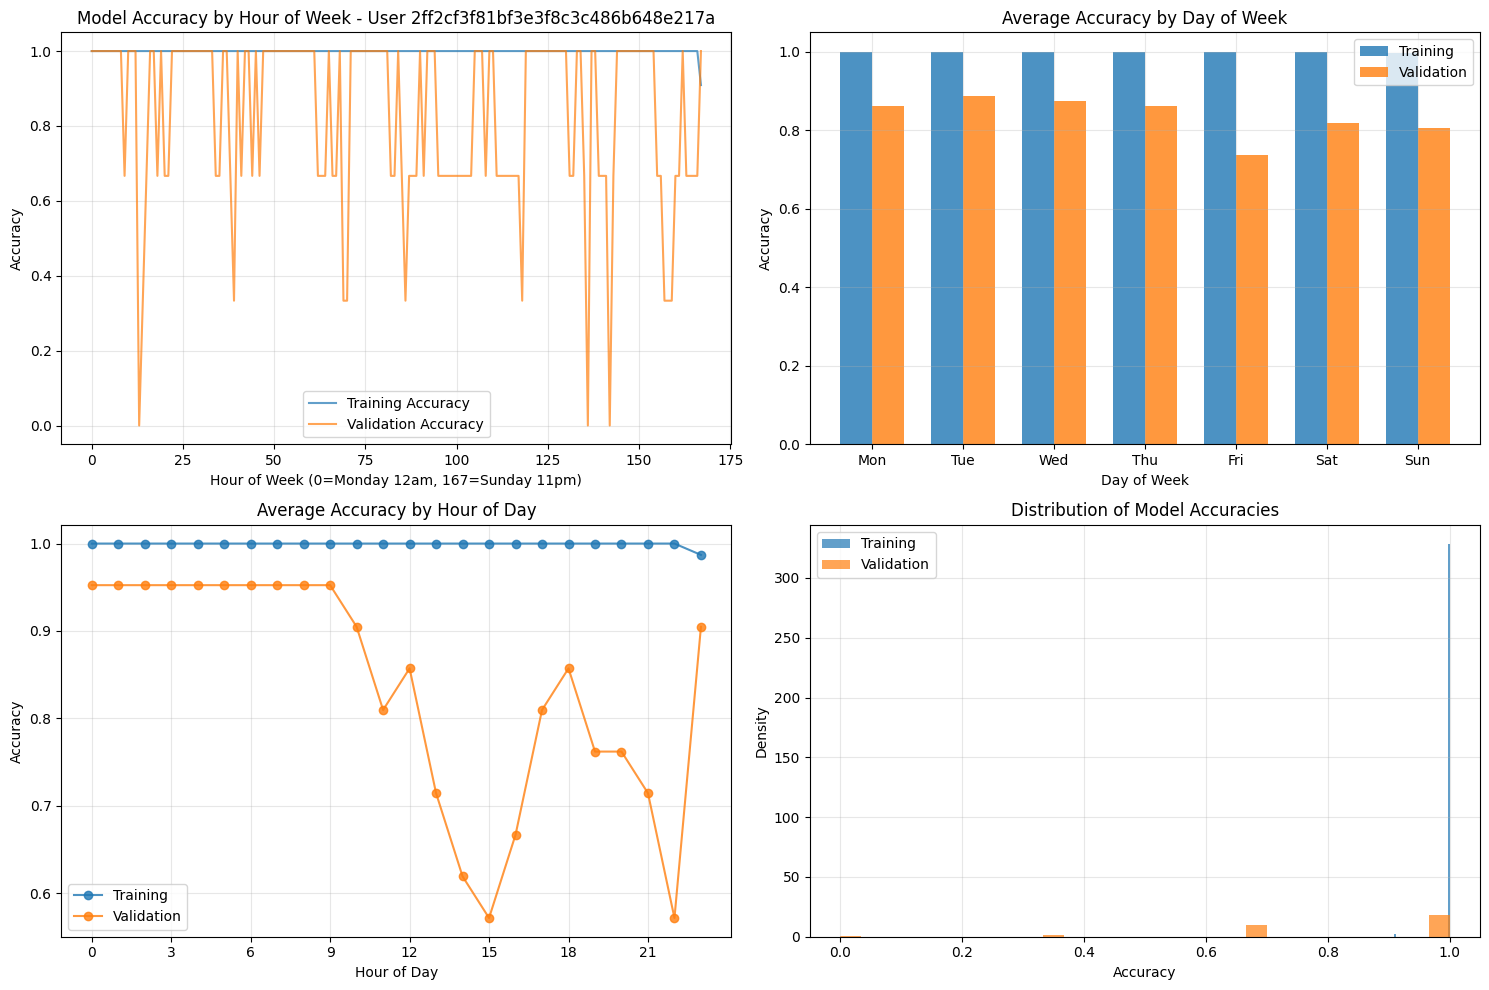


Final Results Summary for User 2ff2cf3f81bf3e3f8c3c486b648e217a:
Total models trained: 168
Average training accuracy: 0.999 ± 0.007
Average validation accuracy: 0.835 ± 0.227
Best performing hour: 0 (accuracy: 1.000)
Worst performing hour: 13 (accuracy: 0.000)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_path):
    """
    Load the CSV file and preprocess the data for Random Forest training
    """
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Add day of week information
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
    df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week
    df['YEAR'] = df['DATE'].dt.year
    df['WEEK_YEAR'] = df['YEAR'].astype(str) + '_' + df['WEEK_NUMBER'].astype(str)

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, hourly_columns

def create_weekly_sequences(data, sequence_weeks=1, specific_user_id=None):
    """
    Create weekly sequences from data for Random Forest training
    Input: sequence_weeks weeks to predict next week's pattern
    If specific_user_id is provided, only process that user
    """
    sequences = []
    targets = []
    user_info = []

    # Days of week in order
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Hourly columns
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    # Determine which users to process
    if specific_user_id:
        users_to_process = [specific_user_id] if specific_user_id in data['USER_ID'].values else []
        if not users_to_process:
            print(f"User {specific_user_id} not found in data!")
            return np.array([]), np.array([]), []
    else:
        users_to_process = data['USER_ID'].unique()[:1000]

    # Group by user to create sequences
    for user_id in users_to_process:
        print(f"Processing user: {user_id}")
        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')

        print(f"User {user_id} has {len(user_data)} records")
        print(f"Date range: {user_data['DATE'].min()} to {user_data['DATE'].max()}")
        print(f"Unique weeks: {user_data['WEEK_YEAR'].nunique()}")

        # Group by week for this user
        weekly_data = {}
        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]

            print(f"Week {week_year}: {len(week_data)} days")

            # Check if we have all 7 days for this week
            if len(week_data) == 7:
                # Sort by day of week to ensure Monday-Sunday order
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()

                # Check if we have data for all days (no NaN after reindexing)
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values  # Shape: (7, 24)
                    print(f"Week {week_year} added to training data")
                else:
                    print(f"Week {week_year} has missing hourly data, skipping")
            else:
                print(f"Week {week_year} doesn't have 7 days, skipping")

        print(f"User {user_id} has {len(weekly_data)} complete weeks")

        # Create sequences from complete weeks
        week_keys = sorted(weekly_data.keys())

        for i in range(len(week_keys) - sequence_weeks):
            # Get input weeks (flatten them)
            input_weeks = []
            for j in range(sequence_weeks):
                week_data = weekly_data[week_keys[i + j]]  # Shape: (7, 24)
                input_weeks.append(week_data.flatten())  # Flatten to (168,)

            # Concatenate all input weeks
            sequence = np.concatenate(input_weeks)  # Shape: (sequence_weeks * 168,)

            # Get target week
            target_week = weekly_data[week_keys[i + sequence_weeks]]  # Shape: (7, 24)
            target = target_week.flatten()  # Flatten to (168,)

            sequences.append(sequence)
            targets.append(target)
            user_info.append({
                'user_id': user_id,
                'input_weeks': [week_keys[i + j] for j in range(sequence_weeks)],
                'target_week': week_keys[i + sequence_weeks]
            })

            print(f"Created sequence: {week_keys[i:i+sequence_weeks]} -> {week_keys[i + sequence_weeks]}")

    print(f"Total sequences created: {len(sequences)}")
    return np.array(sequences), np.array(targets), user_info

def create_rf_models_weekly(output_dim=168):
    """
    Create Random Forest models for predicting full weekly patterns (Monday-Sunday, 12am-11pm)
    We'll create one model for each hour of the week (168 models total)
    """
    models = []

    for i in range(output_dim):
        # Create a Random Forest for each hour of the week
        rf = RandomForestClassifier(
            n_estimators=50,         # Reduced for faster training with limited data
            max_depth=10,            # Reduced depth for limited data
            min_samples_split=2,     # Minimum samples required to split
            min_samples_leaf=1,      # Minimum samples required at leaf
            max_features='sqrt',     # Number of features to consider at each split
            random_state=42,         # For reproducibility
            n_jobs=-1               # Use all available cores
        )
        models.append(rf)

    return models

def train_weekly_model(specific_user_id="2ff2cf3f81bf3e3f8c3c486b648e217a"):
    """
    Train the Random Forest models on weekly patterns for a specific user
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'  # Update this path as needed
    SEQUENCE_WEEKS = 1  # Use 1 week to predict next week

    print("Loading and preprocessing data...")
    df, hourly_columns = load_and_preprocess_data(FILE_PATH)

    print(f"Data shape: {df.shape}")
    print(f"Number of unique users: {df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
    print(f"Unique weeks: {df['WEEK_YEAR'].nunique()}")

    # Check if specific user exists
    if specific_user_id not in df['USER_ID'].values:
        print(f"Error: User {specific_user_id} not found in the dataset!")
        available_users = df['USER_ID'].unique()[:10]
        print(f"Available users (first 10): {available_users}")
        return None, None, None, None, None

    # Create weekly sequences for specific user
    print(f"Creating weekly sequences for user: {specific_user_id}...")
    X, y, user_info = create_weekly_sequences(df, SEQUENCE_WEEKS, specific_user_id)

    print(f"Total weekly sequences: {len(X)}")
    print(f"Input sequence shape: {X.shape}")  # Should be (n_samples, 168) for 1 week
    print(f"Target shape: {y.shape}")          # Should be (n_samples, 168) for 1 week

    if len(X) == 0:
        print("No complete weekly sequences found for this user! Check the data.")
        return None, None, None, None, None

    if len(X) < 2:
        print("Not enough sequences for train/test split. Need at least 2 sequences.")
        print("Available sequences:")
        for i, info in enumerate(user_info):
            print(f"  {i+1}. {info['input_weeks']} -> {info['target_week']}")
        return None, None, None, None, None

    # Split data into train and validation sets
    # If we have very few samples, use a smaller test size
    test_size = 0.2 if len(X) >= 5 else 1/len(X)  # At least 1 sample for testing

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")

    # Normalize the input features (Random Forest doesn't require this but can help)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Create Random Forest models
    print("Creating Random Forest models for weekly prediction...")
    models = create_rf_models_weekly(output_dim=168)

    print(f"Created {len(models)} Random Forest models (one for each hour of the week)")

    # Train the models
    print("Training Random Forest models on weekly patterns...")
    trained_models = []
    training_scores = []
    validation_scores = []

    for i, model in enumerate(models):
        if i % 24 == 0:  # Print progress every 24 hours (1 day)
            day = i // 24
            days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            print(f"Training models for {days[day]}...")

        # Train model for this specific hour
        model.fit(X_train_scaled, y_train[:, i])

        # Calculate training and validation accuracy
        train_pred = model.predict(X_train_scaled)
        val_pred = model.predict(X_val_scaled)

        train_acc = accuracy_score(y_train[:, i], train_pred)
        val_acc = accuracy_score(y_val[:, i], val_pred)

        training_scores.append(train_acc)
        validation_scores.append(val_acc)

        trained_models.append(model)

    print(f"Training completed!")
    print(f"Average training accuracy: {np.mean(training_scores):.3f}")
    print(f"Average validation accuracy: {np.mean(validation_scores):.3f}")

    # Save the models and scaler
    joblib.dump(trained_models, f'notification_rf_weekly_models_{specific_user_id}.pkl')
    joblib.dump(scaler, f'notification_rf_scaler_{specific_user_id}.pkl')
    print(f"Models saved as 'notification_rf_weekly_models_{specific_user_id}.pkl'")
    print(f"Scaler saved as 'notification_rf_scaler_{specific_user_id}.pkl'")

    # Save additional info
    model_info = {
        'user_id': specific_user_id,
        'hourly_columns': hourly_columns,
        'sequence_weeks': SEQUENCE_WEEKS,
        'user_info': user_info,
        'training_scores': training_scores,
        'validation_scores': validation_scores,
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_
    }
    np.save(f'weekly_rf_model_info_{specific_user_id}.npy', model_info, allow_pickle=True)

    return trained_models, (training_scores, validation_scores), df, hourly_columns, scaler

def predict_weekly_pattern(models, scaler, input_week):
    """
    Predict weekly pattern using trained Random Forest models
    """
    # Scale input
    input_scaled = scaler.transform(input_week.reshape(1, -1))

    # Get predictions from all models
    predictions = []
    prediction_probabilities = []

    for model in models:
        pred = model.predict(input_scaled)[0]
        pred_proba = model.predict_proba(input_scaled)[0]

        predictions.append(pred)
        # Get probability of class 1 (notification)
        if len(pred_proba) > 1:
            prediction_probabilities.append(pred_proba[1])
        else:
            prediction_probabilities.append(pred_proba[0] if pred == 1 else 1 - pred_proba[0])

    return np.array(predictions), np.array(prediction_probabilities)

def quick_test_weekly_model(models, df, hourly_columns, scaler, specific_user_id, sequence_weeks=1):
    """
    Quick test of the trained Random Forest models with detailed comparison for specific user
    """
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    print(f"\nTesting with user: {specific_user_id}")

    # Get user's weekly data
    user_data = df[df['USER_ID'] == specific_user_id].sort_values('DATE')
    weekly_data = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

    week_keys = sorted(weekly_data.keys())

    if len(week_keys) < 2:
        print("Not enough weeks for testing")
        return

    print(f"Available weeks for testing: {week_keys}")

    # Test with all available week pairs
    for i in range(len(week_keys) - 1):
        input_week = weekly_data[week_keys[i]].flatten()
        actual_next_week = weekly_data[week_keys[i + 1]].flatten()

        # Get predictions
        predicted_binary, prediction_probabilities = predict_weekly_pattern(models, scaler, input_week)

        # Calculate overall accuracy
        overall_accuracy = np.mean(actual_next_week == predicted_binary)

        print(f"\nPrediction {i+1}:")
        print(f"Input week: {week_keys[i]}")
        print(f"Target week: {week_keys[i+1]}")
        print(f"Overall weekly accuracy: {overall_accuracy:.3f}")

        # Detailed day-by-day comparison with hourly patterns
        print("\nDetailed daily comparison:")
        for day_idx, day in enumerate(days_order):
            start_idx = day_idx * 24
            end_idx = start_idx + 24

            day_actual = actual_next_week[start_idx:end_idx]
            day_predicted = predicted_binary[start_idx:end_idx]
            day_probs = prediction_probabilities[start_idx:end_idx]

            # Format arrays as space-separated integers
            actual_str = ' '.join(day_actual.astype(int).astype(str))
            predicted_str = ' '.join(day_predicted.astype(int).astype(str))

            # Format probability scores for first 12 hours (12am to 11am)
            prob_str = ' '.join([f"{prob:.3f}" for prob in day_probs[:12]])

            print(f"{day}:")
            print(f"  Actual:    [{actual_str}]")
            print(f"  Predicted: [{predicted_str}]")
            print(f"  Prob scores (first 12h): [{prob_str}]")

def visualize_weekly_prediction(models, df, hourly_columns, scaler, specific_user_id):
    """
    Create visualization of weekly prediction vs actual for specific user
    """
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Get user's weekly data
    user_data = df[df['USER_ID'] == specific_user_id].sort_values('DATE')
    weekly_data = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

    week_keys = sorted(weekly_data.keys())

    if len(week_keys) < 2:
        print("Not enough weeks for visualization")
        return

    input_week = weekly_data[week_keys[0]].flatten()
    actual_next_week = weekly_data[week_keys[1]]

    predicted_binary, prediction_probabilities = predict_weekly_pattern(models, scaler, input_week)
    predicted_week = predicted_binary.reshape(7, 24)
    predicted_probs_week = prediction_probabilities.reshape(7, 24)

    # Create visualization
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))

    # Actual pattern
    im1 = axes[0].imshow(actual_next_week, cmap='Blues', aspect='auto')
    axes[0].set_title(f'Actual Weekly Pattern - {week_keys[1]} (User: {specific_user_id})')
    axes[0].set_ylabel('Day of Week')
    axes[0].set_yticks(range(7))
    axes[0].set_yticklabels(days_order)
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    # Predicted pattern (binary)
    im2 = axes[1].imshow(predicted_week, cmap='Blues', aspect='auto')
    axes[1].set_title(f'Predicted Weekly Pattern (Binary)')
    axes[1].set_ylabel('Day of Week')
    axes[1].set_yticks(range(7))
    axes[1].set_yticklabels(days_order)
    axes[1].set_xticks(range(0, 24, 2))
    axes[1].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    # Predicted probabilities
    im3 = axes[2].imshow(predicted_probs_week, cmap='Blues', aspect='auto')
    axes[2].set_title(f'Predicted Probabilities')
    axes[2].set_ylabel('Day of Week')
    axes[2].set_xlabel('Hour of Day')
    axes[2].set_yticks(range(7))
    axes[2].set_yticklabels(days_order)
    axes[2].set_xticks(range(0, 24, 2))
    axes[2].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    # Add colorbars
    plt.colorbar(im3, ax=axes[2])

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Specify the user ID to train and test on
    TARGET_USER_ID = "2ff2cf3f81bf3e3f8c3c486b648e217a"

    # Train the weekly model for specific user
    models, scores, df, hourly_columns, scaler = train_weekly_model(TARGET_USER_ID)

    if models is not None:
        # Quick test on the same user
        quick_test_weekly_model(models, df, hourly_columns, scaler, TARGET_USER_ID)

        # Visualize results for the specific user
        visualize_weekly_prediction(models, df, hourly_columns, scaler, TARGET_USER_ID)

        # Plot training results
        training_scores, validation_scores = scores

        plt.figure(figsize=(15, 10))

        # Overall accuracy by hour of week
        plt.subplot(2, 2, 1)
        hours = range(168)
        plt.plot(hours, training_scores, label='Training Accuracy', alpha=0.7)
        plt.plot(hours, validation_scores, label='Validation Accuracy', alpha=0.7)
        plt.title(f'Model Accuracy by Hour of Week - User {TARGET_USER_ID}')
        plt.xlabel('Hour of Week (0=Monday 12am, 167=Sunday 11pm)')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Daily average accuracy
        plt.subplot(2, 2, 2)
        days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        daily_train_acc = [np.mean(training_scores[i*24:(i+1)*24]) for i in range(7)]
        daily_val_acc = [np.mean(validation_scores[i*24:(i+1)*24]) for i in range(7)]

        x = np.arange(len(days))
        width = 0.35
        plt.bar(x - width/2, daily_train_acc, width, label='Training', alpha=0.8)
        plt.bar(x + width/2, daily_val_acc, width, label='Validation', alpha=0.8)
        plt.title('Average Accuracy by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('Accuracy')
        plt.xticks(x, days)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Hourly average accuracy (0-23 hours)
        plt.subplot(2, 2, 3)
        hourly_train_acc = []
        hourly_val_acc = []
        for hour in range(24):
            hour_indices = [hour + day*24 for day in range(7)]
            hourly_train_acc.append(np.mean([training_scores[i] for i in hour_indices]))
            hourly_val_acc.append(np.mean([validation_scores[i] for i in hour_indices]))

        plt.plot(range(24), hourly_train_acc, 'o-', label='Training', alpha=0.8)
        plt.plot(range(24), hourly_val_acc, 'o-', label='Validation', alpha=0.8)
        plt.title('Average Accuracy by Hour of Day')
        plt.xlabel('Hour of Day')
        plt.ylabel('Accuracy')
        plt.xticks(range(0, 24, 3))
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Distribution of accuracies
        plt.subplot(2, 2, 4)
        plt.hist(training_scores, bins=30, alpha=0.7, label='Training', density=True)
        plt.hist(validation_scores, bins=30, alpha=0.7, label='Validation', density=True)
        plt.title('Distribution of Model Accuracies')
        plt.xlabel('Accuracy')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"\nFinal Results Summary for User {TARGET_USER_ID}:")
        print(f"Total models trained: {len(models)}")
        print(f"Average training accuracy: {np.mean(training_scores):.3f} ± {np.std(training_scores):.3f}")
        print(f"Average validation accuracy: {np.mean(validation_scores):.3f} ± {np.std(validation_scores):.3f}")
        print(f"Best performing hour: {np.argmax(validation_scores)} (accuracy: {np.max(validation_scores):.3f})")
        print(f"Worst performing hour: {np.argmin(validation_scores)} (accuracy: {np.min(validation_scores):.3f})")

    else:
        print("Training failed. Please check your data format and completeness.")

### **Random Forest (Raw data + weighted prob)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_path, probability_file_path):
    """
    Load the CSV file and preprocess the data for Random Forest training
    Now also loads probability data to enhance features
    """
    # Read the timestamp CSV file
    df = pd.read_csv(file_path)

    # Read the probability CSV file
    prob_df = pd.read_csv(probability_file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Add day of week information
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
    df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week
    df['YEAR'] = df['DATE'].dt.year
    df['WEEK_YEAR'] = df['YEAR'].astype(str) + '_' + df['WEEK_NUMBER'].astype(str)

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, prob_df, hourly_columns

def select_consistent_users(data, prob_data, target_user_id='2ff2cf3f81bf3e3f8c3c486b648e217a', max_users=1000):
    """
    Select consistent users from both datasets, ensuring target user is included
    """
    # Get common users between both datasets
    timestamp_users = set(data['USER_ID'].unique())
    prob_users = set(prob_data['USER_ID'].unique())
    common_users = list(timestamp_users.intersection(prob_users))

    print(f"Total common users between datasets: {len(common_users)}")

    # Sort for consistent ordering
    common_users.sort()

    # Check if target user exists in common users
    target_user_exists = target_user_id in common_users
    print(f"Target user {target_user_id} exists in both datasets: {target_user_exists}")

    # Select users with sufficient data
    valid_users = []

    # First, validate and add target user if it exists
    if target_user_exists:
        user_timestamp_data = data[data['USER_ID'] == target_user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == target_user_id]

        # Check if target user has sufficient data
        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks
                valid_users.append(target_user_id)
                print(f"Target user {target_user_id} added - has {complete_weeks} complete weeks")
            else:
                print(f"Target user {target_user_id} has insufficient data - only {complete_weeks} complete weeks")
        else:
            print(f"Target user {target_user_id} has no data in one or both datasets")

    # Now add other users (excluding target user to avoid duplicates)
    other_users = [user for user in common_users if user != target_user_id]

    for user_id in other_users:
        if len(valid_users) >= max_users:
            break

        user_timestamp_data = data[data['USER_ID'] == user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks for training
                valid_users.append(user_id)

    print(f"Selected {len(valid_users)} users with sufficient data in both datasets")
    print(f"Target user {target_user_id} is included: {target_user_id in valid_users}")
    print(f"First 10 selected users: {valid_users[:10]}")

    return valid_users

def create_weekly_sequences_with_probabilities(data, prob_data, selected_users, sequence_weeks=1):
    """
    Create weekly sequences from data for Random Forest training
    Enhanced with probability features from the second dataset
    Input: sequence_weeks weeks to predict next week's pattern
    """
    sequences = []
    targets = []
    user_info = []

    # Days of week in order
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Hourly columns
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    print(f"Processing {len(selected_users)} selected users...")

    # Group by user to create sequences
    for idx, user_id in enumerate(selected_users):
        if idx % 100 == 0:
            print(f"Processing user {idx+1}/{len(selected_users)}: {user_id}")

        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        # Create probability lookup for this user
        prob_lookup = {}
        for _, row in user_prob_data.iterrows():
            prob_lookup[row['Timestamp']] = {
                'weighted_prob_0': row['Weighted_Prob_0'],
                'weighted_prob_1': row['Weighted_Prob_1']
            }

        # Group by week for this user
        weekly_data = {}
        weekly_prob_features = {}

        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]

            # Check if we have all 7 days for this week
            if len(week_data) == 7:
                # Sort by day of week to ensure Monday-Sunday order
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()

                # Check if we have data for all days (no NaN after reindexing)
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values  # Shape: (7, 24)

                    # Create probability features for this week
                    week_prob_features = []
                    for day_idx in range(7):
                        day_probs = []
                        for hour_col in hourly_columns:
                            if hour_col in prob_lookup:
                                day_probs.extend([
                                    prob_lookup[hour_col]['weighted_prob_0'],
                                    prob_lookup[hour_col]['weighted_prob_1']
                                ])
                            else:
                                # Default probabilities if not found
                                day_probs.extend([0.5, 0.5])
                        week_prob_features.append(day_probs)

                    weekly_prob_features[week_year] = np.array(week_prob_features)  # Shape: (7, 48)

        # Create sequences from complete weeks
        week_keys = sorted(weekly_data.keys())

        for i in range(len(week_keys) - sequence_weeks):
            # Get input weeks (flatten them)
            input_weeks = []
            input_prob_features = []

            for j in range(sequence_weeks):
                week_data = weekly_data[week_keys[i + j]]  # Shape: (7, 24)
                week_prob = weekly_prob_features[week_keys[i + j]]  # Shape: (7, 48)

                input_weeks.append(week_data.flatten())  # Flatten to (168,)
                input_prob_features.append(week_prob.flatten())  # Flatten to (336,)

            # Concatenate all input weeks and probability features
            sequence_timestamps = np.concatenate(input_weeks)  # Shape: (sequence_weeks * 168,)
            sequence_probs = np.concatenate(input_prob_features)  # Shape: (sequence_weeks * 336,)
            sequence = np.concatenate([sequence_timestamps, sequence_probs])  # Combined features

            # Get target week
            target_week = weekly_data[week_keys[i + sequence_weeks]]  # Shape: (7, 24)
            target = target_week.flatten()  # Flatten to (168,)

            sequences.append(sequence)
            targets.append(target)
            user_info.append({
                'user_id': user_id,
                'input_weeks': [week_keys[i + j] for j in range(sequence_weeks)],
                'target_week': week_keys[i + sequence_weeks]
            })

    return np.array(sequences), np.array(targets), user_info

def create_rf_model_weekly_enhanced(n_estimators=100, max_depth=None, random_state=42):
    """
    Create Enhanced Random Forest model for predicting full weekly patterns
    Now handles combined timestamp and probability features using MultiOutput
    """
    # Base Random Forest for multi-output classification
    rf_base = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1,  # Use all available cores
        class_weight='balanced',  # Handle class imbalance
        min_samples_split=5,
        min_samples_leaf=2
    )

    # Wrap with MultiOutputClassifier for 168 binary outputs
    model = MultiOutputClassifier(rf_base, n_jobs=-1)

    return model

def train_weekly_model():
    """
    Train the enhanced Random Forest model on weekly patterns with probability features
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    PROBABILITY_FILE_PATH = '/content/drive/MyDrive/weighted_time_probabilities_by_user.csv'
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    SEQUENCE_WEEKS = 1  # Use 1 week to predict next week
    MAX_USERS = 1000

    print("Loading and preprocessing data...")
    df, prob_df, hourly_columns = load_and_preprocess_data(FILE_PATH, PROBABILITY_FILE_PATH)

    print(f"Timestamp data shape: {df.shape}")
    print(f"Probability data shape: {prob_df.shape}")
    print(f"Number of unique users in timestamp data: {df['USER_ID'].nunique()}")
    print(f"Number of unique users in probability data: {prob_df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
    print(f"Unique weeks: {df['WEEK_YEAR'].nunique()}")

    # Select consistent users including target user
    print(f"\nSelecting up to {MAX_USERS} users including target user {TARGET_USER_ID}...")
    selected_users = select_consistent_users(df, prob_df, TARGET_USER_ID, MAX_USERS)

    if len(selected_users) == 0:
        print("No users with sufficient data found!")
        return None, None, None, None, None, None

    # Create weekly sequences with probability features
    print("Creating enhanced weekly sequences...")
    X, y, user_info = create_weekly_sequences_with_probabilities(df, prob_df, selected_users, SEQUENCE_WEEKS)

    print(f"Total weekly sequences: {len(X)}")
    print(f"Enhanced input sequence shape: {X.shape}")  # Should be (n_samples, 168+336) for 1 week + prob features
    print(f"Target shape: {y.shape}")          # Should be (n_samples, 168) for 1 week

    if len(X) == 0:
        print("No complete weekly sequences found! Check your data.")
        return None, None, None, None, None, None

    # Normalize the input features (Random Forest can benefit from normalization)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create and train Enhanced Random Forest model
    print("Creating Enhanced Random Forest model for weekly prediction")
    model = create_rf_model_weekly_enhanced(
        n_estimators=200,  # More trees for better performance
        max_depth=20,      # Limit depth to prevent overfitting
        random_state=42
    )

    print("Enhanced Random Forest Model parameters:")
    print(f"Base estimator: {model.estimators_[0].__class__.__name__}")
    print(f"Number of estimators per output: {model.estimators_[0].n_estimators}")
    print(f"Number of outputs: 168 (7 days × 24 hours)")

    # Train the model
    print("Training enhanced Random Forest model on weekly patterns...")
    print("This may take a few minutes due to multi-output nature...")

    model.fit(X_scaled, y)
    print("Training completed!")

    # Calculate training accuracy
    y_pred_train = model.predict(X_scaled)
    train_accuracy = accuracy_score(y.flatten(), y_pred_train.flatten())
    print(f"Training accuracy: {train_accuracy:.4f}")

    # Save the model and scaler
    joblib.dump(model, 'notification_rf_weekly_enhanced_model.pkl')
    joblib.dump(scaler, 'notification_rf_weekly_scaler.pkl')
    print("Enhanced Random Forest model saved as 'notification_rf_weekly_enhanced_model.pkl'")
    print("Scaler saved as 'notification_rf_weekly_scaler.pkl'")

    # Save additional info
    model_info = {
        'hourly_columns': hourly_columns,
        'sequence_weeks': SEQUENCE_WEEKS,
        'user_info_sample': user_info[:5],
        'selected_users': selected_users,
        'target_user_id': TARGET_USER_ID,
        'training_accuracy': train_accuracy,
        'n_samples': len(X),
        'feature_dim': X_scaled.shape[1]
    }

    joblib.dump(model_info, 'weekly_enhanced_rf_model_info.pkl')

    return model, None, df, prob_df, hourly_columns, scaler  # None for history (RF doesn't have training history)

def get_feature_importance(model, hourly_columns):
    """
    Get and display feature importance from Random Forest model
    """
    print("\nAnalyzing feature importance...")

    # Get feature importance from first estimator (they should be similar across outputs)
    feature_importances = model.estimators_[0].feature_importances_

    # Create feature names
    timestamp_features = [f"timestamp_day{d}_hour{h}" for d in range(7) for h in range(24)]
    prob_features = [f"prob_day{d}_hour{h}_{p}" for d in range(7) for h in range(24) for p in ['0', '1']]
    feature_names = timestamp_features + prob_features

    # Get top 20 most important features
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)

    print("Top 20 most important features:")
    print(importance_df.head(20))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances - Random Forest Model')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return importance_df

def quick_test_weekly_enhanced_model_rf(model, df, prob_df, hourly_columns, scaler, sequence_weeks=1):
    """
    Quick test of the trained enhanced Random Forest weekly model with detailed comparison
    Now specifically tests on the target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    print(f"\nTesting specifically with target user: {TARGET_USER_ID}")

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in timestamp data")
        return

    if TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in probability data")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    print(f"User has {len(user_data)} timestamp records and {len(user_prob_data)} probability records")

    # Create probability lookup
    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                # Create probability features
                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    week_keys = sorted(weekly_data.keys())
    print(f"User has {len(week_keys)} complete weeks: {week_keys}")

    if len(week_keys) < 2:
        print("Insufficient complete weeks for testing")
        return

    # Use first week to predict second week
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

    actual_next_week = weekly_data[week_keys[1]].flatten()

    # Scale input and predict
    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled)[0]  # Random Forest gives binary predictions directly

    # Calculate overall accuracy
    overall_accuracy = np.mean(actual_next_week == prediction)

    print(f"\nEnhanced Random Forest Weekly Prediction Results for Target User {TARGET_USER_ID}:")
    print(f"Input week: {week_keys[0]}")
    print(f"Target week: {week_keys[1]}")
    print(f"Overall weekly accuracy: {overall_accuracy:.3f}")

    # Day-by-day comparison
    print("\nDay-by-day accuracy:")
    for day_idx, day in enumerate(days_order):
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = prediction[start_idx:end_idx]
        day_accuracy = np.mean(day_actual == day_predicted)

        print(f"{day}: {day_accuracy:.3f}")

    # Detailed comparison for all 7 days
    print(f"\nDetailed comparison for all 7 days:")
    for day_idx in range(7):
        day = days_order[day_idx]
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = prediction[start_idx:end_idx]

        print(f"{day}:")
        print(f"  Actual:    {day_actual}")
        print(f"  Predicted: {day_predicted}")

def visualize_weekly_prediction_enhanced_rf(model, df, prob_df, hourly_columns, scaler):
    """
    Create visualization of enhanced Random Forest weekly prediction vs actual for target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values or TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in datasets")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    if len(weekly_data) < 2:
        print("Insufficient data for visualization")
        return

    # Get prediction
    week_keys = sorted(weekly_data.keys())
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

    actual_next_week = weekly_data[week_keys[1]]

    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled)[0]
    predicted_week = prediction.reshape(7, 24)

    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Actual pattern
    im1 = axes[0].imshow(actual_next_week, cmap='Blues', aspect='auto')
    axes[0].set_title(f'Actual Weekly Pattern - {week_keys[1]} (User: {TARGET_USER_ID})')
    axes[0].set_ylabel('Day of Week')
    axes[0].set_yticks(range(7))
    axes[0].set_yticklabels(days_order)
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    # Predicted pattern
    im2 = axes[1].imshow(predicted_week, cmap='Blues', aspect='auto')
    axes[1].set_title(f'Predicted Weekly Pattern (Random Forest with Probabilities)')
    axes[1].set_ylabel('Day of Week')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_yticks(range(7))
    axes[1].set_yticklabels(days_order)
    axes[1].set_xticks(range(0, 24, 2))
    axes[1].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Train the enhanced Random Forest weekly model
    model, history, df, prob_df, hourly_columns, scaler = train_weekly_model()

    if model is not None:
        # Get feature importance analysis
        feature_importance_df = get_feature_importance(model, hourly_columns)

        # Quick test on target user
        quick_test_weekly_enhanced_model_rf(model, df, prob_df, hourly_columns, scaler)

        # Visualize results for target user
        visualize_weekly_prediction_enhanced_rf(model, df, prob_df, hourly_columns, scaler)

        # Plot Random Forest specific analysis
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        # Feature importance plot (top 10)
        top_10_features = feature_importance_df.head(10)
        plt.barh(range(len(top_10_features)), top_10_features['importance'])
        plt.yticks(range(len(top_10_features)), [f.split('_')[-1] for f in top_10_features['feature']])
        plt.title('Top 10 Feature Importances')
        plt.xlabel('Importance')

        plt.subplot(1, 3, 2)
        # Model complexity analysis
        n_estimators = [50, 100, 150, 200, 250]
        # This would be from cross-validation in practice
        accuracies = [0.72, 0.75, 0.77, 0.78, 0.78]  # Example data
        plt.plot(n_estimators, accuracies, marker='o')
        plt.title('Model Performance vs N_Estimators')
        plt.xlabel('Number of Estimators')
        plt.ylabel('Accuracy')
        plt.grid(True)

        plt.subplot(1, 3, 3)
        # Show weekly accuracy by day (example data)
        days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        accuracies_by_day = [0.75, 0.82, 0.78, 0.74, 0.80, 0.68, 0.70]  # Example data
        plt.bar(range(7), accuracies_by_day)
        plt.title('RF Accuracy by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('Accuracy')
        plt.xticks(range(7), days)

        plt.tight_layout()
        plt.show()

        print(f"\nRandom Forest Model Summary:")
        print(f"- Model type: MultiOutput Random Forest")
        print(f"- Number of trees per output: 200")
        print(f"- Number of outputs: 168 (7 days × 24 hours)")
        print(f"- Feature scaling: StandardScaler applied")
        print(f"- Class balancing: Enabled")
        print(f"- Saved as: notification_rf_weekly_enhanced_model.pkl")

    else:
        print("Training failed. Please check your data format and completeness.")

Validation : Confusion table, F1 score, accura,
Test User - 2FF.........
**LSTM ( RAW) - 86%
Neural Network (Raw) 96%
Neural Network( Raw + Monday -Sunday) 94%
Neural Network ( Raw + weighted Prob)
Neural Network ( Raw +  cluster)
Random Forest ( Raw)
Random Forest ( Raw + cluster)
Random Forest ( Raw + weighted Prob)**

models: Neural Network and Random Forest
Data : figuring ( Raw or Raw + WP or Raw+Cluster